## Импортируемые модули

In [34]:
import sys
sys.path.append("/Users/admin/Desktop/diploma")

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.optimize import minimize
from utilites import preprocess
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import RepeatedKFold
from scipy.optimize import minimize
import numpy.ma as mask
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample, check_random_state

#algos
from runc import RuncDualizer
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from models import BoostingElementaryPredicates, BoostingElementaryPredicatesv2
from bagging_trees import BaggingElementaryPredicates

from tqdm import tqdm
from math import sqrt
import math
import itertools
from sklearn.datasets import load_diabetes
from sklearn.datasets import make_regression
import numpy as np
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from own_forest import *
from utilites import *
from own_forest import *
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from ucimlrepo import fetch_ucirepo 

from time import time
from ucimlrepo import fetch_ucirepo 
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
class BaggingElementaryPredicates(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator=None, n_estimators=10, sub_sample_size=1.0, sub_feature_size=1.0, bootstrap=True, bootstrap_features=True, n_jobs=None, random_state=None):
        self.base_estimator = base_estimator if base_estimator is not None else BoostingElementaryPredicates()
        self.base_params = base_estimator.get_params() if base_estimator is not None else {}
        # print(self.base_params)
        self.n_estimators = n_estimators
        self.sub_sample_size = sub_sample_size
        self.sub_feature_size = sub_feature_size
        self.bootstrap = bootstrap
        self.bootstrap_features = bootstrap_features
        self.n_jobs = n_jobs
        self.random_state = random_state

    def fit(self, X, y):
        self.random_state_ = np.random.RandomState(self.random_state)
        seeds = self.random_state_.randint(np.iinfo(np.int32).max, size=self.n_estimators)

        self.estimators_ = []
        self.estimators_features_ = []

        if self.n_jobs is None:
            for seed in seeds:
                estimator, features = self._fit_estimator(X, y, seed)
                self.estimators_.append(estimator)
                self.estimators_features_.append(features)
        else:
            results = Parallel(n_jobs=self.n_jobs)(delayed(self._fit_estimator)(X, y, seed) for seed in seeds)
            self.estimators_, self.estimators_features_ = zip(*results)

        return self

    def _fit_estimator(self, X, y, seed):
        rng = np.random.default_rng(seed)
        samples = generate_bagging_indices(rng, X.shape[0], self.sub_sample_size, self.bootstrap)
        if self.bootstrap_features:
            features = generate_bagging_indices(rng, X.shape[1], self.sub_feature_size, self.bootstrap)
        else:
            features = np.arange(X.shape[1])

        estimator = self.base_estimator.__class__(**self.base_params)
        estimator.fit(X[samples][:, features], y[samples])
        
        return estimator, features

    def predict(self, X):
        predictions = np.mean([est.predict(X[:, features]) for est, features in zip(self.estimators_, self.estimators_features_)], axis=0)
        return predictions

## Эксперименты

## Automobile

In [18]:
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 

data = pd.concat([X, y], axis=1)

data = data.dropna()

X_train, X_val, X_test, y_train, y_val, y_test = preprocess(data, 'mpg')

In [19]:
combinations = [BoostingElementaryPredicatesv2(num_iter=i, m=j, max_cov=500, learning_rate=0.9)
                for i in np.linspace(300, 600, 5).astype(int)
                for j in range(2, 21)]

In [20]:
combinations_dict = {str(index): combo for index, combo in enumerate(combinations)}

In [21]:
combinations_dict['19']

BoostingElementaryPredicatesv2(learning_rate=0.9, m=2, max_cov=500,
                               num_iter=375)

In [24]:
best_params_bg = {
                'base_estimator': BoostingElementaryPredicatesv2(num_iter=375, m=2, max_cov=500, learning_rate=0.9), 'n_estimators': 44,
                'sub_sample_size': 0.35360842588960645, 'sub_feature_size': 0.9529572003771984, 
                'bootstrap': True, 
                'bootstrap_features': False, 
                'n_jobs': 1
                }

tree_numbers = [10, 44, 100]

In [23]:
results_4 = {
    'Number of Estimators': [],
    'Model': [],
    'R2 Score': []
}

In [26]:
for n_estimators in tree_numbers:
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=3, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_r2 = r2_score(y_test, rf_pred)
    results_4['Number of Estimators'].append(n_estimators)
    results_4['Model'].append('RandomForest')
    results_4['R2 Score'].append(rf_r2)

    bg = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                          n_estimators=n_estimators, random_state=42)
    bg.fit(X_train, y_train)
    bg_pred = bg.predict(X_test)
    bg_r2 = r2_score(y_test, bg_pred)
    results_4['Number of Estimators'].append(n_estimators)
    results_4['Model'].append('Bagging with Decision Trees')
    results_4['R2 Score'].append(bg_r2)
    
    bep_params_copy = best_params_bg.copy()
    bep_params_copy['n_estimators'] = n_estimators
    bep = BaggingElementaryPredicates(**bep_params_copy)
    bep.fit(X_train, y_train)
    bep_pred = bep.predict(X_test)
    bep_r2 = r2_score(y_test, bep_pred)
    results_4['Number of Estimators'].append(n_estimators)
    results_4['Model'].append('BaggingElementaryPredicates')
    results_4['R2 Score'].append(bep_r2)

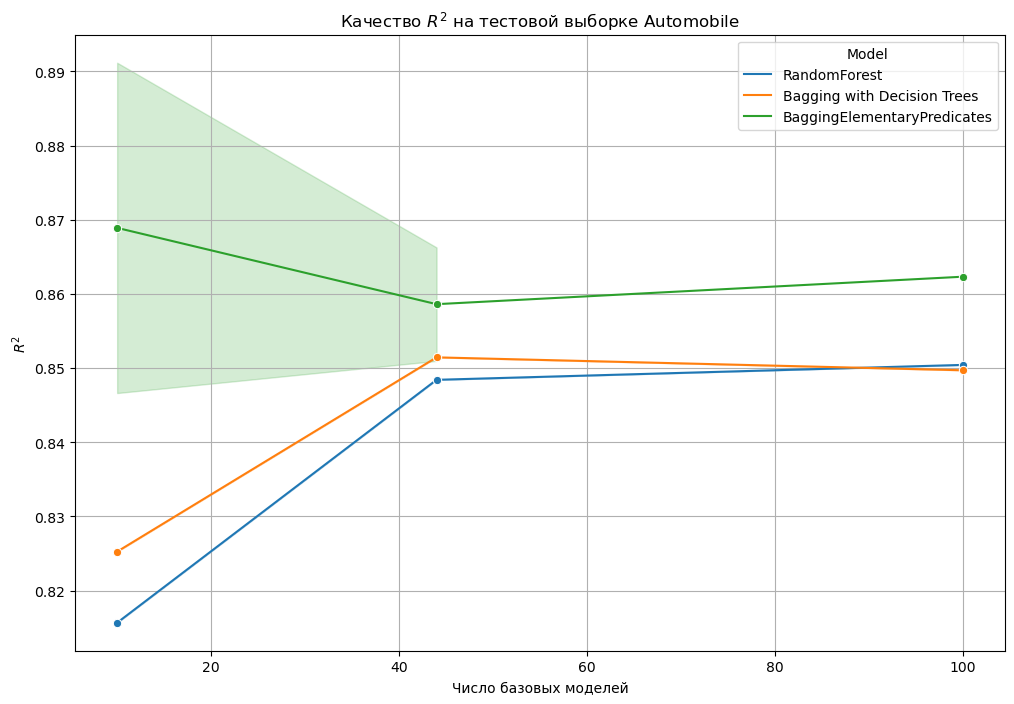

In [33]:
results_df_4 = pd.DataFrame(results_4)

# Визуализация данных
plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df_4, x='Number of Estimators', y='R2 Score', hue='Model', marker='o')
plt.title('Качество $R^2$ на тестовой выборке Automobile')
plt.xlabel('Число базовых моделей')
plt.ylabel('$R^2$')
plt.legend(title='Model')
plt.grid(True)

plt.savefig('comparison_r2_bagg_automobile.png')
plt.show()

In [28]:
results_df_4

,Number of Estimators,Model,R2 Score
0,10,RandomForest,0.815661
1,10,Bagging with Decision Trees,0.825246
2,10,BaggingElementaryPredicates,0.846627
3,44,RandomForest,0.848409
4,44,Bagging with Decision Trees,0.851436
5,44,BaggingElementaryPredicates,0.850957
6,100,RandomForest,0.850420
7,100,Bagging with Decision Trees,0.849697
8,10,RandomForest,0.815661
9,10,Bagging with Decision Trees,0.825246


## Yachts Hydrodynamics

In [336]:
data = pd.read_csv('datasets/02_yachts.csv', sep=',', header=None)

In [337]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(data, 6)

In [338]:
combinations = [BoostingElementaryPredicatesv2(num_iter=i, m=j, max_cov=500, learning_rate=1.0)
                for i in np.linspace(300, 600, 5).astype(int)
                for j in range(2, 21)]

# Создаем словарь для отображения индексов в объекты
combinations_dict = {str(index): combo for index, combo in enumerate(combinations)}

In [339]:
combinations_dict['89']

BoostingElementaryPredicatesv2(m=15, max_cov=500, num_iter=600)

In [340]:
best_params_bg = {
                  'base_estimator': BoostingElementaryPredicatesv2(num_iter=600, m=15, max_cov=500), 'n_estimators': 49,
                  'sub_sample_size': 0.4985349278653848, 'sub_feature_size': 0.9184572651673866, 
                  'bootstrap': True, 'bootstrap_features': False, 'n_jobs': 1
                  }

tree_numbers = [10, 49, 100]

In [341]:
results_2 = {
    'Number of Estimators': [],
    'Model': [],
    'R2 Score': []
}

In [342]:
for n_estimators in tree_numbers:
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=3, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_r2 = r2_score(y_test, rf_pred)
    results_2['Number of Estimators'].append(n_estimators)
    results_2['Model'].append('RandomForest')
    results_2['R2 Score'].append(rf_r2)

    bg = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                          n_estimators=n_estimators, random_state=42)
    bg.fit(X_train, y_train)
    bg_pred = bg.predict(X_test)
    bg_r2 = r2_score(y_test, bg_pred)
    results_2['Number of Estimators'].append(n_estimators)
    results_2['Model'].append('Bagging with Decision Trees')
    results_2['R2 Score'].append(bg_r2)
    
    bep_params_copy = best_params_bg.copy()
    bep_params_copy['n_estimators'] = n_estimators
    bep = BaggingElementaryPredicates(**bep_params_copy)
    bep.fit(X_train, y_train)
    bep_pred = bep.predict(X_test)
    bep_r2 = r2_score(y_test, bep_pred)
    results_2['Number of Estimators'].append(n_estimators)
    results_2['Model'].append('BaggingElementaryPredicates')
    results_2['R2 Score'].append(bep_r2)

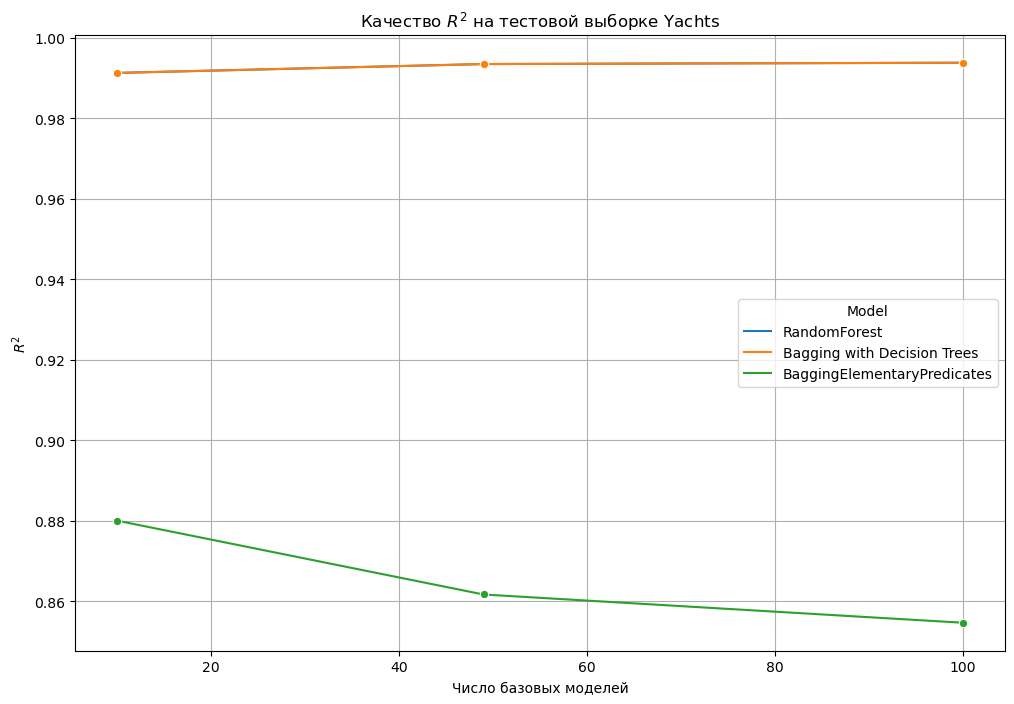

In [349]:
results_df_2 = pd.DataFrame(results_2)

# Визуализация данных
plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df_2, x='Number of Estimators', y='R2 Score', hue='Model', marker='o')
plt.title('Качество $R^2$ на тестовой выборке Yachts')
plt.xlabel('Число базовых моделей')
plt.ylabel('$R^2$')
plt.legend(title='Model')
plt.grid(True)

plt.savefig('comparison_r2_bagg_yachts.png')
plt.show()

## Computer hardware

Датасет "Computer Hardware" из ресурса UCI содержит информацию о характеристиках компьютерного оборудования.

Число прецедентов (наблюдений) в датасете составляет 209. Каждое наблюдение представляет собой информацию о различных признаках компьютера.

Датасет содержит следующие признаки (характеристики) и их значения:

1. Vendor Name (название производителя компьютера)
   - Принимаемые значения: 'adviser', 'amdahl', 'apollo', 'basf', 'bti', 'burroughs', 'c.r.d', 'cambex', 'cdc', 'dec', 'dg', 'formation', 'four-phase', 'gould', 'harris', 'honeywell', 'hp', 'ibm', 'ipl', 'magnuson', 'microdata', 'nas', 'ncr', 'nixdorf', 'perkin-elmer', 'prime', 'siemens', 'sperry', 'sratus', 'wang'
   
2. Model Name (название модели компьютера)
   - Принимаемые значения: Текстовые значения, уникальные для каждой модели компьютера.
   
3. Machine Cycle Time (MYCT) (максимальное число циклов работы, миллионы тактов за одну минуту)
   - Диапазон значений: 17, 1500
   
4. Minimum Main Memory (MMIN) (минимальное число памяти в килобайтах)
   - Диапазон значений: 64, 32000
   
5. Maximum Main Memory (MMAX) (максимальное число памяти в килобайтах)
   - Диапазон значений: 64, 64000

6. Cache Memory (CACH) (размер кэша памяти в килобайтах)
   - Диапазон значений: 0, 256

7. Minimum Number of Channels (CHMIN) (минимальное число каналов ввода-вывода)
   - Диапазон значений: 0, 52

8. Maximum Number of Channels (CHMAX) (максимальное число каналов ввода-вывода)
   - Диапазон значений: 0, 176

9. Published Relative Performance (PRP) (рейтинг производительности компьютера)
   - Диапазон значений: 6, 1500

10. Estimated Relative Performance (ERP) (средняя эффективность работы компьютера)
    - Диапазон значений: 15, 1238

In [252]:
computer_hardware = fetch_ucirepo(id=29) 
  
# data (as pandas dataframes) 
X = computer_hardware.data.features 
y = computer_hardware.data.targets 
  
# metadata 
print(computer_hardware.metadata) 
  
# variable information 
print(computer_hardware.variables) 

{'uci_id': 29, 'name': 'Computer Hardware', 'repository_url': 'https://archive.ics.uci.edu/dataset/29/computer+hardware', 'data_url': 'https://archive.ics.uci.edu/static/public/29/data.csv', 'abstract': 'Relative CPU Performance Data, described in terms of its cycle time, memory size, etc.', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 209, 'num_features': 10, 'feature_types': ['Integer'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1987, 'last_updated': 'Fri Oct 27 2023', 'dataset_doi': '10.24432/C5830D', 'creators': ['Jacob Feldmesser'], 'intro_paper': None, 'additional_info': {'summary': 'The estimated relative performance values were estimated by the authors using a linear regression method.  See their article (pp 308-313) for more details on how the relative performance values were set.', 'purpose': None, 'funded_by': N

In [253]:
computer_hardware.variables

,name,role,type,demographic,description,units,missing_values
0,VendorName,Feature,Categorical,None,"(adviser, amdahl,apollo, basf, bti, burroughs,...",None,no
1,ModelName,Feature,Categorical,None,many unique symbols,None,no
2,MYCT,Feature,Integer,None,machine cycle time,nanoseconds,no
3,MMIN,Feature,Integer,None,minimum main memory,kilobytes,no
4,MMAX,Feature,Integer,None,maximum main memory,kilobytes,no
5,CACH,Feature,Integer,None,cache memory,kilobytes,no
6,CHMIN,Feature,Integer,None,minimum channels,units,no
7,CHMAX,Feature,Integer,None,maximum channels,units,no
8,PRP,Feature,Integer,None,published relative performance,None,no
9,ERP,Feature,Integer,None,estimated relative performance from the origin...,None,no


In [254]:
X.shape

(209, 10)

In [14]:
X

,VendorName,ModelName,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
0,adviser,32/60,125,256,6000,256,16,128,198
1,amdahl,470v/7,29,8000,32000,32,8,32,269
2,amdahl,470v/7a,29,8000,32000,32,8,32,220
3,amdahl,470v/7b,29,8000,32000,32,8,32,172
4,amdahl,470v/7c,29,8000,16000,32,8,16,132
...,...,...,...,...,...,...,...,...,...
204,sperry,80/8,124,1000,8000,0,1,8,42
205,sperry,90/80-model-3,98,1000,8000,32,2,8,46
206,sratus,32,125,2000,8000,0,2,14,52
207,wang,vs-100,480,512,8000,32,0,0,67


In [255]:
X['ModelName'].value_counts()

ModelName
32/60     1
38/7      1
m80/32    1
m80/42    1
m80/43    1
         ..
100       1
300       1
500       1
600       1
vs-90     1
Name: count, Length: 209, dtype: int64

Удалим признак с названием модели, так как он уникальный для каждого объекта.

In [256]:
X = X.drop(columns='ModelName', axis=1)

In [257]:
len(X['VendorName'].value_counts())

30

In [258]:
X

,VendorName,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,125,256,6000,256,16,128,198,199
1,amdahl,29,8000,32000,32,8,32,269,253
2,amdahl,29,8000,32000,32,8,32,220,253
3,amdahl,29,8000,32000,32,8,32,172,253
4,amdahl,29,8000,16000,32,8,16,132,132
...,...,...,...,...,...,...,...,...,...
204,sperry,124,1000,8000,0,1,8,42,37
205,sperry,98,1000,8000,32,2,8,46,50
206,sratus,125,2000,8000,0,2,14,52,41
207,wang,480,512,8000,32,0,0,67,47


In [260]:
def preprocess(data, target_name, drop=True, index_col=None):
    if isinstance(data, (str, )):
        if index_col is not None:
            df = pd.read_csv(data, index_col=index_col).reset_index()
        else:
            df = pd.read_csv(data)

    else:
        df = data.copy()
    
    if drop and 'index' in df.columns:
        df = df.drop(columns='index')

    # Splitting the dataset into features and target
    X_raw = df.drop(columns=[target_name])
    
    y = df[target_name].to_numpy()
    # y = df[target_name]

    # Normalizing numerical features
    numeric_cols = X_raw.select_dtypes(include=['number']).columns
    scaler = StandardScaler()
    X_raw[numeric_cols] = scaler.fit_transform(X_raw[numeric_cols])

    # Encoding categorical variables
    X_raw = pd.get_dummies(X_raw, drop_first=True)

    # Splitting data into training, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_raw, y, train_size=0.8, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, random_state=42)

    return X_train.to_numpy(), X_val.to_numpy(), X_test.to_numpy(), y_train, y_val, y_test

Признак с названием производителя закодируем с помощью One-Hot Encoding.

In [261]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(X, 'PRP')

In [262]:
X_train.shape

(167, 36)

In [275]:
combinations = [BoostingElementaryPredicatesv2(num_iter=i, m=j, max_cov=500, learning_rate=1.0)
                for i in np.linspace(300, 600, 5).astype(int)
                for j in range(2, 21)]

# Создаем словарь для отображения индексов в объекты
combinations_dict = {str(index): combo for index, combo in enumerate(combinations)}

In [276]:
combinations_dict['40']

BoostingElementaryPredicatesv2(m=4, max_cov=500, num_iter=450)

In [303]:
best_params_bg = {'base_estimator': BoostingElementaryPredicatesv2(num_iter=450, m=4, max_cov=500, learning_rate=0.1), 
                  'n_estimators': 87, 
                  'sub_sample_size': 0.6631703755655713, 
                  'sub_feature_size': 0.7506091267097661, 'bootstrap': True,
                    'bootstrap_features': False, 'n_jobs': 1
                }

tree_numbers = [10, 20, 60, 140, 200, 400]

In [304]:
results_1 = {
    'Number of Estimators': [],
    'Model': [],
    'R2 Score': []
}

In [305]:
for n_estimators in tree_numbers:
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_r2 = r2_score(y_test, rf_pred)
    results_1['Number of Estimators'].append(n_estimators)
    results_1['Model'].append('RandomForest')
    results_1['R2 Score'].append(rf_r2)

    bg = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                          n_estimators=n_estimators, random_state=42)
    bg.fit(X_train, y_train)
    bg_pred = bg.predict(X_test)
    bg_r2 = r2_score(y_test, bg_pred)
    results_1['Number of Estimators'].append(n_estimators)
    results_1['Model'].append('Bagging with Decision Trees')
    results_1['R2 Score'].append(bg_r2)
    
    bep_params_copy = best_params_bg.copy()
    bep_params_copy['n_estimators'] = n_estimators
    bep = BaggingElementaryPredicates(**bep_params_copy)
    bep.fit(X_train, y_train)
    bep_pred = bep.predict(X_test)
    bep_r2 = r2_score(y_test, bep_pred)
    results_1['Number of Estimators'].append(n_estimators)
    results_1['Model'].append('BaggingElementaryPredicates')
    results_1['R2 Score'].append(bep_r2)

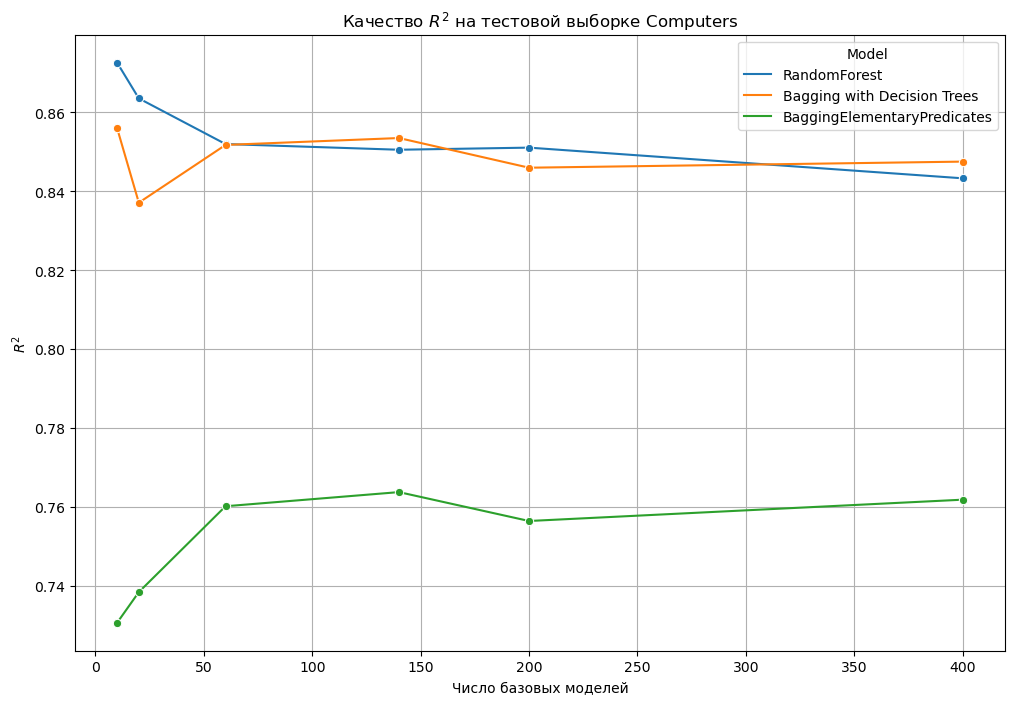

In [306]:
results_df_1 = pd.DataFrame(results_1)

# Визуализация данных
plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df_1, x='Number of Estimators', y='R2 Score', hue='Model', marker='o')
plt.title('Качество $R^2$ на тестовой выборке Computers')
plt.xlabel('Число базовых моделей')
plt.ylabel('$R^2$')
plt.legend(title='Model')
plt.grid(True)

plt.savefig('comparison_r2_bagg.png')
plt.show()

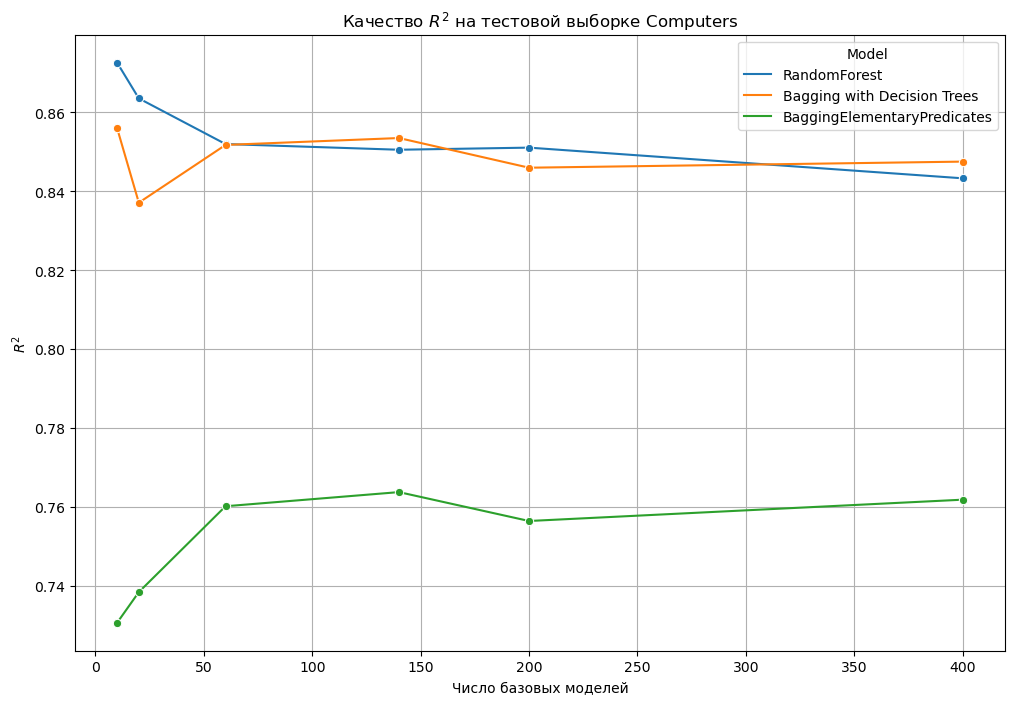

In [331]:
results_df_1 = pd.DataFrame(results_1)

# Визуализация данных
plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df_1, x='Number of Estimators', y='R2 Score', hue='Model', marker='o')
plt.title('Качество $R^2$ на тестовой выборке Computers')
plt.xlabel('Число базовых моделей')
plt.ylabel('$R^2$')
plt.legend(title='Model')
plt.grid(True)

plt.savefig('comparison_r2_bagg_comps.png')

## Auto MPG

In [103]:
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 

In [55]:
auto_mpg.variables

,name,role,type,demographic,description,units,missing_values
0,displacement,Feature,Continuous,None,None,None,no
1,mpg,Target,Continuous,None,None,None,no
2,cylinders,Feature,Integer,None,None,None,no
3,horsepower,Feature,Continuous,None,None,None,yes
4,weight,Feature,Continuous,None,None,None,no
5,acceleration,Feature,Continuous,None,None,None,no
6,model_year,Feature,Integer,None,None,None,no
7,origin,Feature,Integer,None,None,None,no
8,car_name,ID,Categorical,None,None,None,no


In [56]:
X

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...
393,140.0,4,86.0,2790,15.6,82,1
394,97.0,4,52.0,2130,24.6,82,2
395,135.0,4,84.0,2295,11.6,82,1
396,120.0,4,79.0,2625,18.6,82,1


In [90]:
X.isna().sum()

displacement    0
cylinders       0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64

In [19]:
y

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0
...,...
393,27.0
394,44.0
395,32.0
396,28.0


In [104]:
data = pd.concat([X, y], axis=1)
data

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
0,307.0,8,130.0,3504,12.0,70,1,18.0
1,350.0,8,165.0,3693,11.5,70,1,15.0
2,318.0,8,150.0,3436,11.0,70,1,18.0
3,304.0,8,150.0,3433,12.0,70,1,16.0
4,302.0,8,140.0,3449,10.5,70,1,17.0
...,...,...,...,...,...,...,...,...
393,140.0,4,86.0,2790,15.6,82,1,27.0
394,97.0,4,52.0,2130,24.6,82,2,44.0
395,135.0,4,84.0,2295,11.6,82,1,32.0
396,120.0,4,79.0,2625,18.6,82,1,28.0


In [105]:
data = data.dropna()

In [60]:
data.shape

(392, 8)

In [23]:
data.dtypes

displacement    float64
cylinders         int64
horsepower      float64
weight            int64
acceleration    float64
model_year        int64
origin            int64
mpg             float64
dtype: object

In [106]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(data, 'mpg')

ValueError: not enough values to unpack (expected 6, got 2)

In [107]:
X_train.shape

(313, 7)

In [109]:
combinations = [BoostingElementaryPredicatesv2(num_iter=i, m=j, max_cov=500, learning_rate=1.0)
                for i in np.linspace(300, 600, 5).astype(int)
                for j in range(2, 21)]

# Создаем словарь для отображения индексов в объекты
combinations_dict = {str(index): combo for index, combo in enumerate(combinations)}


In [13]:
combinations_dict['91']

BoostingElementaryPredicatesv2(m=17, max_cov=500, num_iter=600)

In [14]:
best_params_bg = {
 'base_estimator': BoostingElementaryPredicatesv2(num_iter=600, m=17, max_cov=500), 
 'n_estimators': 100, 'sub_sample_size': 0.674140153195861, 
 'sub_feature_size': 0.5822353932534229, 
 'bootstrap': True, 'bootstrap_features': False, 'n_jobs': 1
 }

tree_numbers = [10, 50, 100]

In [26]:
results = {
    'Number of Estimators': [],
    'Model': [],
    'R2 Score': []
}


In [27]:
for n_estimators in tree_numbers:
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_r2 = r2_score(y_test, rf_pred)
    results['Number of Estimators'].append(n_estimators)
    results['Model'].append('RandomForest')
    results['R2 Score'].append(rf_r2)

    bg = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                          n_estimators=n_estimators, random_state=42)
    bg.fit(X_train, y_train)
    bg_pred = bg.predict(X_test)
    bg_r2 = r2_score(y_test, bg_pred)
    results['Number of Estimators'].append(n_estimators)
    results['Model'].append('Bagging with Decision Trees')
    results['R2 Score'].append(bg_r2)
    
    bep_params_copy = best_params_bg.copy()
    bep_params_copy['n_estimators'] = n_estimators
    bep = BaggingElementaryPredicates(**bep_params_copy)
    bep.fit(X_train, y_train)
    bep_pred = bep.predict(X_test)
    bep_r2 = r2_score(y_test, bep_pred)
    results['Number of Estimators'].append(n_estimators)
    results['Model'].append('BaggingElementaryPredicates')
    results['R2 Score'].append(bep_r2)

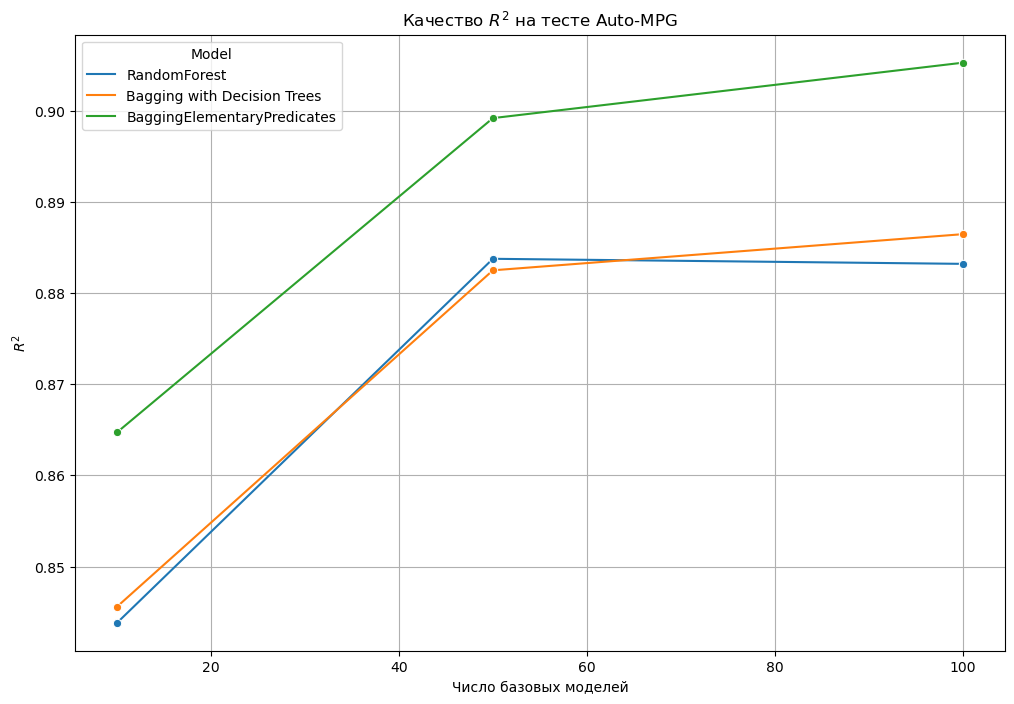

In [127]:
results_df = pd.DataFrame(results)

# Визуализация данных
plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df, x='Number of Estimators', y='R2 Score', hue='Model', marker='o')
plt.title('Качество $R^2$ на тесте Auto-MPG')
plt.xlabel('Число базовых моделей')
plt.ylabel('$R^2$')
plt.legend(title='Model')
plt.grid(True)

plt.savefig('comparison_r2_bagg.png')
plt.show()

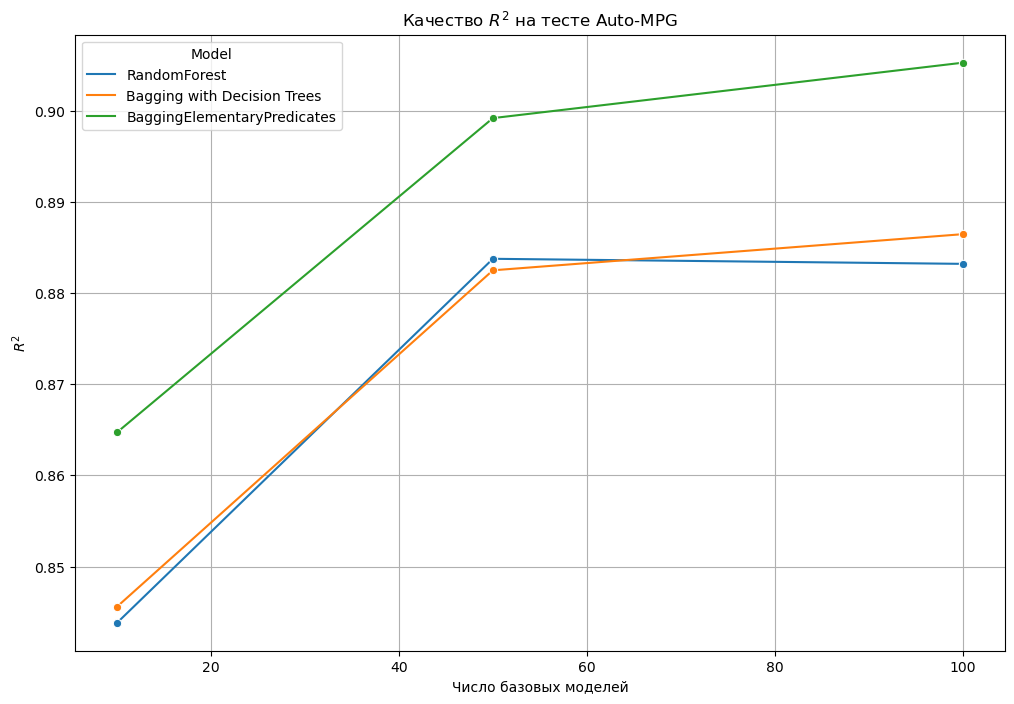

In [332]:
results_df = pd.DataFrame(results)

# Визуализация данных
plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df, x='Number of Estimators', y='R2 Score', hue='Model', marker='o')
plt.title('Качество $R^2$ на тесте Auto-MPG')
plt.xlabel('Число базовых моделей')
plt.ylabel('$R^2$')
plt.legend(title='Model')
plt.grid(True)

plt.savefig('comparison_r2_bagg_mpg.png')
plt.show()

In [98]:
dataset_name = 'Auto_MPG'

# be_params = {
#      'base_estimator': [BoostingElementaryPredicatesv2(num_iter=533, m=20, max_cov=500, learning_rate=0.5)],
#      'n_estimators': [10, 50, 100, 150, 200],
#      'sub_sample_size': [0.3, 0.5, 0.7, 0.9],  # от 0.5 до 1.0
#      'sub_feature_size': [0.7, 0.9, 1.0],  # от 0.5 до 1.0
#      'bootstrap': [True, False],
#     'bootstrap_features': [True, False],
#      'n_jobs': [4]  # 4 processor
#  }

be_params = {'base_estimator': BoostingElementaryPredicatesv2(num_iter=1144, m=2, max_cov=500, learning_rate=0.1), 
             'n_estimators': [13, 20, 50, 100], 'sub_sample_size': 0.4733930620755578, 'sub_feature_size': 0.7091376639606527, 
             'bootstrap': True, 'bootstrap_features': False, 'n_jobs': 1}

bg_params = {
    'n_estimators': [10, 20, 50, 100],
    'base_estimator': DecisionTreeRegressor(max_depth=3),
}

rf_params = {
    'n_estimators': [10, 20, 50, 100], 
    'max_depth': 3
}

models = [ 
    ("BaggingElementaryPredicates", BaggingElementaryPredicates(base_estimator=BoostingElementaryPredicatesv2(num_iter=1144, m=2, max_cov=500, learning_rate=0.1)), be_params),
    ("BaggingRegressor", BaggingRegressor(n_jobs=1), bg_params),
    ("RandomForestRegressor", RandomForestRegressor(n_jobs=1), rf_params)
]

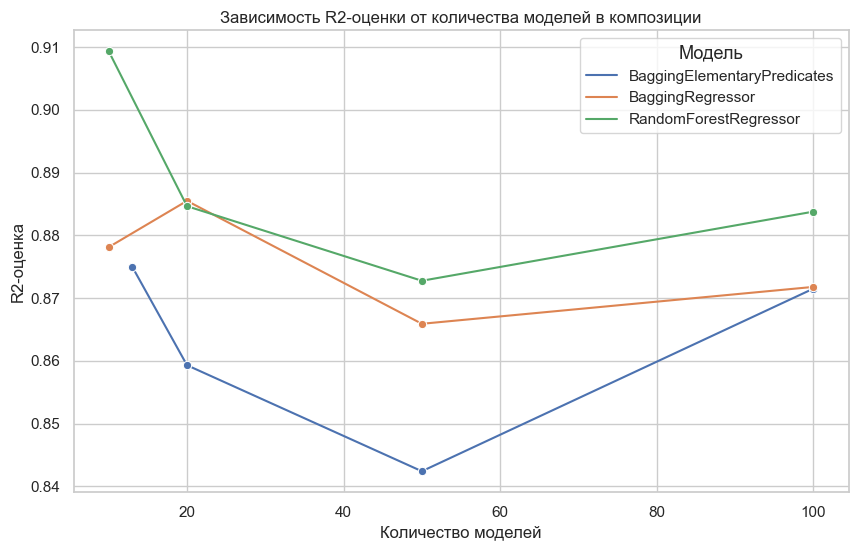

In [102]:
data = {
    'n_estimators': [13, 20, 50, 100, 10, 20, 50, 100, 10, 20, 50, 100],
    'r2_score': [0.8750, 0.8593, 0.8424, 0.8715, 0.878121, 0.885497, 0.865903, 0.871781, 0.909344, 0.884649, 0.872761, 0.883779],
    'model': [
        'BaggingElementaryPredicates', 'BaggingElementaryPredicates', 'BaggingElementaryPredicates', 'BaggingElementaryPredicates',
        'BaggingRegressor', 'BaggingRegressor', 'BaggingRegressor', 'BaggingRegressor',
        'RandomForestRegressor', 'RandomForestRegressor', 'RandomForestRegressor', 'RandomForestRegressor'
    ]
}

# Создаем DataFrame
results_df = pd.DataFrame(data)

# Построение графика
plt.figure(figsize=(10, 6))
plot = sns.lineplot(data=results_df, x='n_estimators', y='r2_score', hue='model', marker='o')
plot.set_title('Зависимость R2-оценки от количества моделей в композиции')
plot.set_xlabel('Количество моделей')
plot.set_ylabel('R2-оценка')
plt.legend(title='Модель', title_fontsize='13', fontsize='11')
plt.savefig('composition_r2_score.png')
plt.show()


In [100]:
results_df

,n_estimators,r2_score,model
0,13,0.758618,BaggingElementaryPredicates
1,20,0.758380,BaggingElementaryPredicates
2,50,0.769613,BaggingElementaryPredicates
3,100,0.754733,BaggingElementaryPredicates
4,10,0.878121,BaggingRegressor
5,20,0.885497,BaggingRegressor
6,50,0.865903,BaggingRegressor
7,100,0.871781,BaggingRegressor
8,10,0.909344,RandomForestRegressor
9,20,0.884649,RandomForestRegressor


## Разброс качества предсказаний 

In [208]:
def preprocess(data, target_name, drop=True, index_col=None):
    if isinstance(data, (str, )):
        if index_col is not None:
            df = pd.read_csv(data, index_col=index_col).reset_index()
        else:
            df = pd.read_csv(data)

    else:
        df = data.copy()
    
    if drop and 'index' in df.columns:
        df = df.drop(columns='index')

    # Splitting the dataset into features and target
    X_raw = df.drop(columns=[target_name])
    
    y = df[target_name].to_numpy()
    # y = df[target_name]

    # Normalizing numerical features
    numeric_cols = X_raw.select_dtypes(include=['number']).columns
    scaler = StandardScaler()
    X_raw[numeric_cols] = scaler.fit_transform(X_raw[numeric_cols])

    # Encoding categorical variables
    X_raw = pd.get_dummies(X_raw, drop_first=True)

    return X_raw, y

In [111]:
X_raw, y = preprocess(data, 'mpg')

In [95]:
X_raw.shape

(392, 7)

In [96]:
y.shape

(392,)

In [112]:
best_params_bg = {
    'base_estimator': BoostingElementaryPredicatesv2(num_iter=600, m=17, max_cov=500), 
    'n_estimators': 50, 'sub_sample_size': 0.674140153195861, 
    'sub_feature_size': 0.5822353932534229, 
    'bootstrap': True, 'bootstrap_features': False, 'n_jobs': 1
}

best_params_bep = {'num_iter': 600, 'm': 17, 'max_cov': 500, 'learning_rate': 1.0}

In [113]:
from time import time

In [114]:
r2_scores_bg = []
r2_scores_bep = []
times_bg = []
times_bep = []

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X_raw, y, train_size=0.8, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, random_state=42 + i)
    
    X_train = X_train.to_numpy()
    X_val = X_val.to_numpy()
    X_test = X_test.to_numpy()

    # BaggingElementaryPredicates
    start_time = time()
    bg_model = BaggingElementaryPredicates(**best_params_bg)
    bg_model.fit(X_train, y_train)
    y_pred_bg = bg_model.predict(X_test)
    end_time = time()

    r2_scores_bg.append(r2_score(y_test, y_pred_bg))
    times_bg.append(end_time - start_time)

    # BoostingElementaryPredicates
    start_time = time()
    bep_model = BoostingElementaryPredicatesv2(**best_params_bep)
    bep_model.fit(X_train, y_train)
    y_pred_bep = bep_model.predict(X_test)
    end_time = time()

    r2_scores_bep.append(r2_score(y_test, y_pred_bep))
    times_bep.append(end_time - start_time)

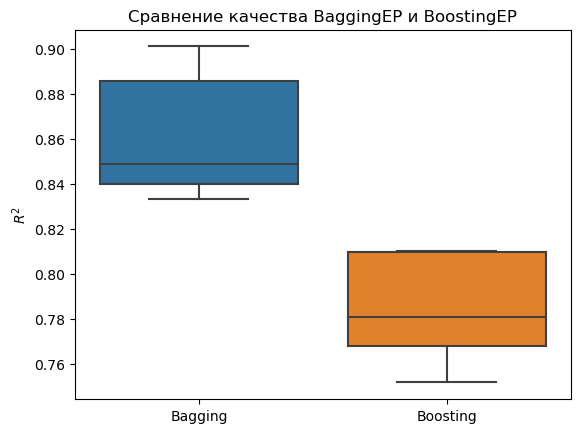

       Модель  Среднее время (с)
0   BaggingEP         148.686063
1  BoostingEP           3.240751


In [309]:
data = {'Bagging': r2_scores_bg, 'Boosting': r2_scores_bep}
df = pd.DataFrame(data)
sns.boxplot(data=df)
plt.title('Сравнение качества BaggingEP и BoostingEP')
plt.ylabel('$R^2$')
plt.savefig('boxplot_r2_boost_bagg.svg', dpi=300)
plt.show()

# Вывод времени выполнения
times_data = pd.DataFrame({
    'Модель': ['BaggingEP', 'BoostingEP'],
    'Среднее время (с)': [np.mean(times_bg), np.mean(times_bep)]
})
print(times_data)

## Датасет NeorChem Prediction

Признаки слитка


        
      NPLAV - номер сертификата ститка. По этому идентификатору можно связать, какие детали были сделаны из одного слитка.

        
      MASS - масса слитка

        
      DIAMETER - диаметр слитка

        
      MASS_STRUG, N_MASS_STRUG - какие-то характеристики слитка (не знаю какие). Надо проверить, что они фиксированы для одинаковых NPLAV

        
      HIM_NAME_STR - список названий хим.элементов в слитке. Например, Al1 - аллюминий сверху, Al2 - аллюминий снизу.

        
      EL_ZN_STR - список значений хим. состава слитка, соответсвующий списку HIM_NAME_STR


Признаки изделия


        
      SOOTV_ID - ?????

        
      MFG_ORDER_ID - некий идентификатор заказа

        
      N_OBR - номер тестируемого образца

        
      NC_ZAK - номер заказа (по-моему, везде одинаковый)

        
      POS_KRAT - позиция в крате. Слиток распиливается на краты. Из крат вырезают заготовки. Каждой заготовке прискаивается номер

        
      KRATA - номер краты в слитке (оказалось, что форма зависимости от KRATA наших таргетов достаточно интересная - надо перепроверить)


Целевые переменные (мех. свойства детали)


        
      PRED_TEK_USL -пределел текучести условный, ksi

        
      VR_SOPR - временное сопротивление, ksi

        
      OTN_UDL - относительное удлинение, %

        
      OTN_SUZ - относительное сужение, %

In [35]:
data = pd.read_csv("neor_him_meh.csv")
print(data.shape)
data

(4836, 17)


,NPLAV,MASS,DIAMETER,MASS_STRUG,N_MASS_STRUG,HIM_NAME_STR,EL_ZN_STR,PRED_TEK_USL,VR_SOPR,OTN_UDL,OTN_SUZ,SOOTV_ID,MFG_ORDER_ID,N_OBR,NC_ZAK,POS_KRAT,KRATA
0,0-08-03401,2184.0,650.0,0.0,908.2,Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...,6.08;6.19;0.20;0.20;0.005;0.005;0.024;0.020;0....,908.0,1007.0,18.3,41.9,1,НЕ ПЛАНИРУЕТСЯ В LPP,VS5953 (NO.5) FL 1,4,1,1
1,0-08-03401,2184.0,650.0,0.0,908.2,Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...,6.08;6.19;0.20;0.20;0.005;0.005;0.024;0.020;0....,897.0,988.0,17.9,41.0,1,НЕ ПЛАНИРУЕТСЯ В LPP,VS5953 FL 2,4,1,1
2,0-08-03401,2184.0,650.0,0.0,908.2,Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...,6.08;6.19;0.20;0.20;0.005;0.005;0.024;0.020;0....,884.0,978.0,17.5,41.8,1,НЕ ПЛАНИРУЕТСЯ В LPP,VS5954 FL 2,4,2,1
3,0-08-03401,2184.0,650.0,0.0,908.2,Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...,6.08;6.19;0.20;0.20;0.005;0.005;0.024;0.020;0....,891.0,990.0,17.5,40.6,1,НЕ ПЛАНИРУЕТСЯ В LPP,VS5955 FL 2,4,3,1
4,0-08-03401,2184.0,650.0,0.0,908.2,Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...,6.08;6.19;0.20;0.20;0.005;0.005;0.024;0.020;0....,885.0,984.0,17.9,41.8,1,НЕ ПЛАНИРУЕТСЯ В LPP,VS5956 FL 2,4,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4831,8-47-01272,4190.0,744.0,0.0,1788.8,Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...,6.48;6.52;0.21;0.18;0.0005;0.0007;0.013;0.013;...,887.0,980.0,17.9,44.6,1,04-0736882-19,VS9185 FL 2,4,5,6
4832,8-47-01272,4190.0,744.0,0.0,1788.8,Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...,6.48;6.52;0.21;0.18;0.0005;0.0007;0.013;0.013;...,899.0,994.0,17.9,42.5,1,04-0736882-19,VS9186 FL 2,4,6,6
4833,8-47-01272,4190.0,744.0,0.0,1788.8,Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...,6.48;6.52;0.21;0.18;0.0005;0.0007;0.013;0.013;...,909.0,1004.0,15.8,38.3,1,04-0736882-19,VS9187 FL 2,4,7,6
4834,8-47-01272,4190.0,744.0,0.0,1788.8,Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...,6.48;6.52;0.21;0.18;0.0005;0.0007;0.013;0.013;...,894.0,991.0,16.7,39.7,1,04-0736882-19,VS9188 FL 2,4,8,6


In [36]:
data.loc[0]['HIM_NAME_STR']

'Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;Y1;Y2;ПК1;ПК2;ПС1;ПС2'

In [37]:
data.loc[0]['EL_ZN_STR']

'6.08;6.19;0.20;0.20;0.005;0.005;0.024;0.020;0.182;0.166;0.029;0.032;3.94;4.04;0.001;0.001;0.10;0.10;0.155;0.15'

EL_ZN_STR разобьем на столбцы с именами из HIM_NAME_STR и сопоставить каждому новому столбцу с названием хим. элемента его значение и так для каждой записи в таблице

In [38]:
def parse_chemical_composition(row):
    him_names = row['HIM_NAME_STR'].split(';')
    el_values = row['EL_ZN_STR'].split(';')
    
    # Создание словаря из хим. элементов и их значений
    composition = {him_names[i]: float(el_values[i]) for i in range(len(him_names))}
    
    return pd.Series(composition)

In [39]:
chemical_data = data.apply(parse_chemical_composition, axis=1)
data = pd.concat([data, chemical_data], axis=1)

In [40]:
data.loc[0]

NPLAV                                                  0-08-03401
MASS                                                       2184.0
DIAMETER                                                    650.0
MASS_STRUG                                                    0.0
N_MASS_STRUG                                                908.2
HIM_NAME_STR    Al1;Al2;Fe1;Fe2;H1;H2;N1;N2;O1;O2;C1;C2;V1;V2;...
EL_ZN_STR       6.08;6.19;0.20;0.20;0.005;0.005;0.024;0.020;0....
PRED_TEK_USL                                                908.0
VR_SOPR                                                    1007.0
OTN_UDL                                                      18.3
OTN_SUZ                                                      41.9
SOOTV_ID                                                        1
MFG_ORDER_ID                                 НЕ ПЛАНИРУЕТСЯ В LPP
N_OBR                                         VS5953  (NO.5) FL 1
NC_ZAK                                                          4
POS_KRAT  

In [41]:
# Удаление исходных столбцов
data = data.drop(columns=['HIM_NAME_STR', 'EL_ZN_STR'])

In [42]:
data.to_csv('neor_him_meh_transformed.csv', index=False)

In [144]:
data

,NPLAV,MASS,DIAMETER,MASS_STRUG,N_MASS_STRUG,PRED_TEK_USL,VR_SOPR,OTN_UDL,OTN_SUZ,SOOTV_ID,...,C1,C2,V1,V2,Y1,Y2,ПК1,ПК2,ПС1,ПС2
0,0-08-03401,2184.0,650.0,0.0,908.2,908.0,1007.0,18.3,41.9,1,...,0.029,0.032,3.94,4.04,0.001,0.001,0.1,0.1,0.155,0.150
1,0-08-03401,2184.0,650.0,0.0,908.2,897.0,988.0,17.9,41.0,1,...,0.029,0.032,3.94,4.04,0.001,0.001,0.1,0.1,0.155,0.150
2,0-08-03401,2184.0,650.0,0.0,908.2,884.0,978.0,17.5,41.8,1,...,0.029,0.032,3.94,4.04,0.001,0.001,0.1,0.1,0.155,0.150
3,0-08-03401,2184.0,650.0,0.0,908.2,891.0,990.0,17.5,40.6,1,...,0.029,0.032,3.94,4.04,0.001,0.001,0.1,0.1,0.155,0.150
4,0-08-03401,2184.0,650.0,0.0,908.2,885.0,984.0,17.9,41.8,1,...,0.029,0.032,3.94,4.04,0.001,0.001,0.1,0.1,0.155,0.150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4831,8-47-01272,4190.0,744.0,0.0,1788.8,887.0,980.0,17.9,44.6,1,...,0.023,0.022,4.22,4.16,0.001,0.001,0.1,0.1,0.077,0.074
4832,8-47-01272,4190.0,744.0,0.0,1788.8,899.0,994.0,17.9,42.5,1,...,0.023,0.022,4.22,4.16,0.001,0.001,0.1,0.1,0.077,0.074
4833,8-47-01272,4190.0,744.0,0.0,1788.8,909.0,1004.0,15.8,38.3,1,...,0.023,0.022,4.22,4.16,0.001,0.001,0.1,0.1,0.077,0.074
4834,8-47-01272,4190.0,744.0,0.0,1788.8,894.0,991.0,16.7,39.7,1,...,0.023,0.022,4.22,4.16,0.001,0.001,0.1,0.1,0.077,0.074


In [224]:
print(data.columns)

Index(['NPLAV', 'MASS', 'DIAMETER', 'MASS_STRUG', 'N_MASS_STRUG',
       'PRED_TEK_USL', 'VR_SOPR', 'OTN_UDL', 'OTN_SUZ', 'SOOTV_ID',
       'MFG_ORDER_ID', 'N_OBR', 'NC_ZAK', 'POS_KRAT', 'KRATA', 'Al1', 'Al2',
       'Fe1', 'Fe2', 'H1', 'H2', 'N1', 'N2', 'O1', 'O2', 'C1', 'C2', 'V1',
       'V2', 'Y1', 'Y2', 'ПК1', 'ПК2', 'ПС1', 'ПС2'],
      dtype='object')


In [225]:
print(data.dtypes)

NPLAV            object
MASS            float64
DIAMETER        float64
MASS_STRUG      float64
N_MASS_STRUG    float64
PRED_TEK_USL    float64
VR_SOPR         float64
OTN_UDL         float64
OTN_SUZ         float64
SOOTV_ID          int64
MFG_ORDER_ID     object
N_OBR            object
NC_ZAK            int64
POS_KRAT          int64
KRATA            object
Al1             float64
Al2             float64
Fe1             float64
Fe2             float64
H1              float64
H2              float64
N1              float64
N2              float64
O1              float64
O2              float64
C1              float64
C2              float64
V1              float64
V2              float64
Y1              float64
Y2              float64
ПК1             float64
ПК2             float64
ПС1             float64
ПС2             float64
dtype: object


In [167]:
data.describe()

,MASS,DIAMETER,MASS_STRUG,N_MASS_STRUG,PRED_TEK_USL,VR_SOPR,OTN_UDL,OTN_SUZ,SOOTV_ID,NC_ZAK,...,C1,C2,V1,V2,Y1,Y2,ПК1,ПК2,ПС1,ПС2
count,4836.000000,4836.000000,4836.000000,4836.000000,4836.000000,4836.00000,4836.000000,4836.000000,4836.000000,4836.0,...,4836.000000,4836.000000,4836.000000,4836.000000,4.836000e+03,4.836000e+03,4836.000000,4836.000000,4836.000000,4836.000000
mean,4466.320306,783.188379,44.480149,1532.189661,899.835723,991.68614,17.440798,40.623077,1.232010,4.0,...,0.024109,0.024120,4.224493,4.215507,1.000000e-03,1.000000e-03,0.099460,0.099460,0.082933,0.084344
std,795.152850,53.762585,177.552618,484.666233,14.391451,14.64716,1.013132,2.179401,1.051092,0.0,...,0.003520,0.003033,0.094954,0.117438,1.040942e-17,1.040942e-17,0.006949,0.006949,0.018189,0.019138
min,2082.000000,650.000000,0.000000,448.000000,856.000000,948.00000,10.000000,31.800000,1.000000,4.0,...,0.019000,0.018000,3.910000,3.880000,1.000000e-03,1.000000e-03,0.010000,0.010000,0.038200,0.034500
25%,4190.000000,744.000000,0.000000,1161.600000,890.000000,981.95750,16.700000,39.200000,1.000000,4.0,...,0.022000,0.022000,4.160000,4.140000,1.000000e-03,1.000000e-03,0.100000,0.100000,0.076000,0.077000
50%,4295.000000,747.000000,0.000000,1498.500000,899.300000,991.00000,17.500000,40.600000,1.000000,4.0,...,0.024000,0.024000,4.240000,4.230000,1.000000e-03,1.000000e-03,0.100000,0.100000,0.084000,0.084000
75%,4695.000000,815.000000,0.000000,1899.500000,909.000000,1000.51750,17.900000,42.000000,1.000000,4.0,...,0.025000,0.025000,4.290000,4.300000,1.000000e-03,1.000000e-03,0.100000,0.100000,0.089000,0.090000
max,5970.000000,959.000000,900.000000,2473.800000,1212.300000,1304.90000,22.100000,49.600000,6.000000,4.0,...,0.040000,0.033000,4.420000,4.480000,1.000000e-03,1.000000e-03,0.100000,0.100000,0.164000,0.173000


In [43]:
# Анализ фиксации характеристик для одинаковых NPLAV
grouped = data.groupby('NPLAV')[['MASS_STRUG', 'N_MASS_STRUG']].nunique()
print(grouped)
fixed = grouped.max(axis=1) == 1
print(f"All measurements fixed for NPLAV: {fixed.all()}")

            MASS_STRUG  N_MASS_STRUG
NPLAV                               
0-08-03401           1             1
0-15-01176           1             1
0-19-12821           1             1
0-19-12829           1             1
0-19-14774           1             1
...                ...           ...
8-45-09979           1             1
8-45-10636           1             1
8-45-11048           1             1
8-46-08146           1             1
8-47-01272           1             1

[80 rows x 2 columns]
All measurements fixed for NPLAV: True


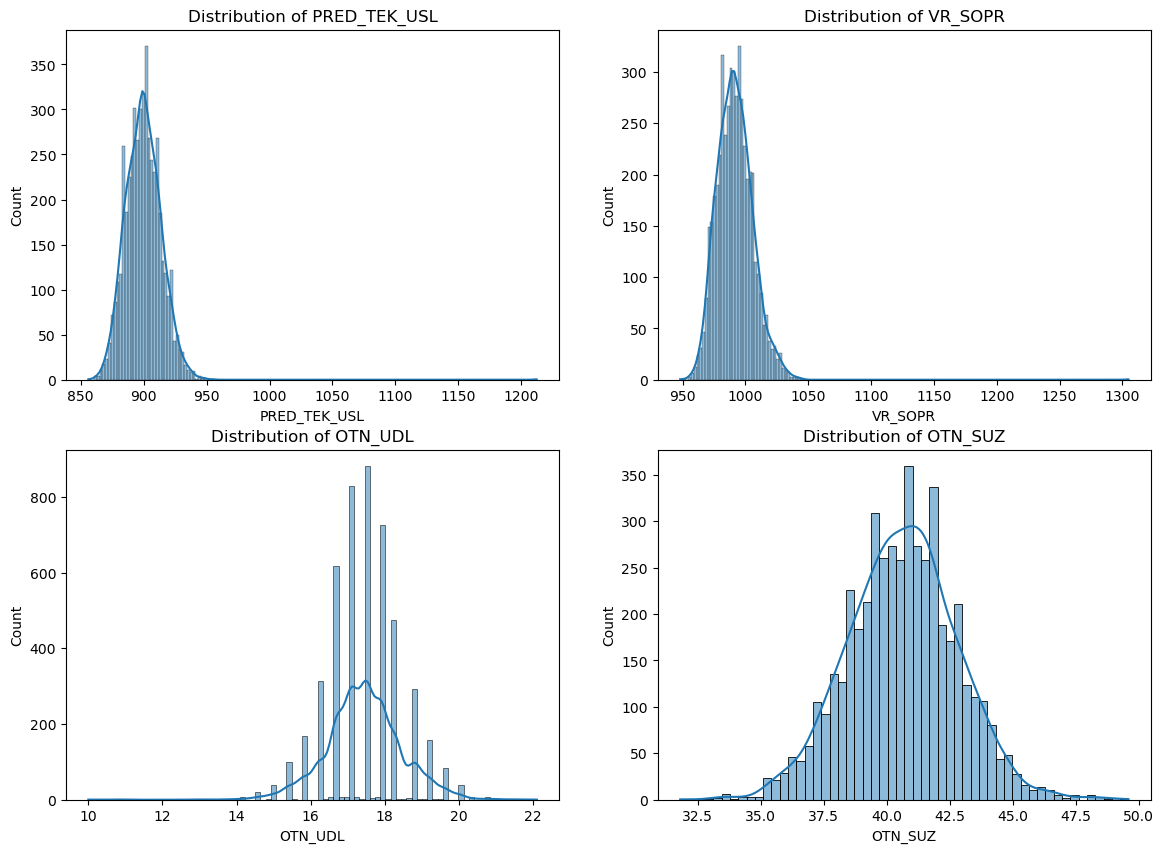

In [169]:
# Визуализация распределений целевых переменных
target_columns = ['PRED_TEK_USL', 'VR_SOPR', 'OTN_UDL', 'OTN_SUZ']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, col in zip(axes.flatten(), target_columns):
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

In [62]:
data1 = data[data['VR_SOPR'] > 1040]

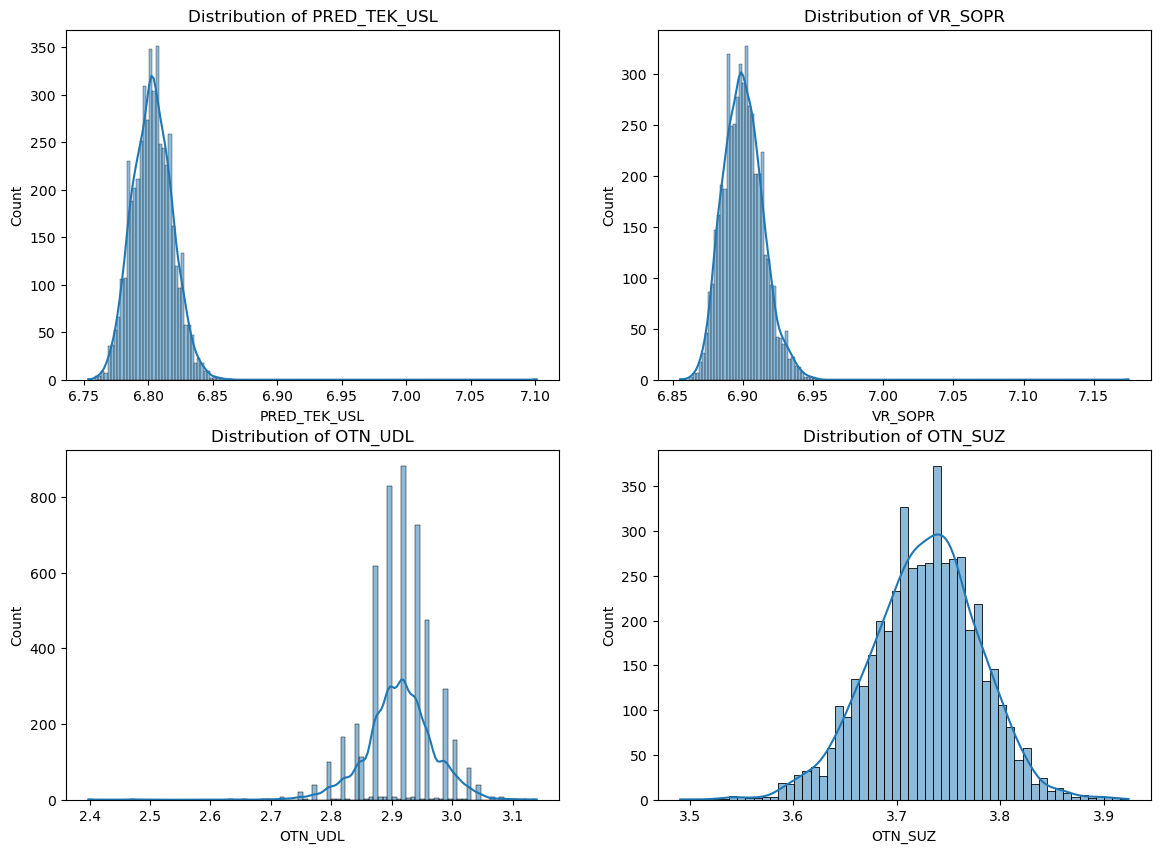

In [67]:
# Визуализация распределений целевых переменных
target_columns = ['PRED_TEK_USL', 'VR_SOPR', 'OTN_UDL', 'OTN_SUZ']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, col in zip(axes.flatten(), target_columns):
    sns.histplot(np.log(data[col] + 1), kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

In [170]:
object_cols = data.select_dtypes(include='object').columns

unique_values = {col: data[col].unique() for col in object_cols}

for col, unique_vals in unique_values.items():
    print(f"{col}: {len(unique_vals)} unique values")
    print(unique_vals[:10])
    print()

# Перечень признаков с типом данных 'object'
print("Признаки с типом данных 'object':")
print(object_cols.tolist())

NPLAV: 80 unique values
['0-08-03401' '0-15-01176' '0-19-12821' '0-19-12829' '0-19-14774'
 '0-21-05803' '0-25-12354' '0-25-12383' '8-02-02227' '8-02-02265']

MFG_ORDER_ID: 31 unique values
['НЕ ПЛАНИРУЕТСЯ В LPP' '04-0731481-19' '04-0401156-18' '04-0401166-18'
 '04-0529398-19' nan '04-0238356-17' '04-0238537-17' '04-0529413-19'
 '04-0046029-16']

N_OBR: 4821 unique values
['VS5953  (NO.5) FL 1' 'VS5953  FL 2' 'VS5954  FL 2' 'VS5955  FL 2'
 'VS5956  FL 2' 'VS5957  FL 2' 'VS5958  FL 2' 'VS5959  FL 2'
 'VS5960  FL 2' 'VS5961  FL 2']

KRATA: 19 unique values
['1' '2' '3' '4' '5' '6' '7' '8' '10' '9']

Признаки с типом данных 'object':
['NPLAV', 'MFG_ORDER_ID', 'N_OBR', 'KRATA']


In [153]:
data.shape

(4836, 35)

In [196]:
data.isna().sum()

NPLAV              0
MASS               0
DIAMETER           0
MASS_STRUG         0
N_MASS_STRUG       0
PRED_TEK_USL       0
VR_SOPR            0
OTN_UDL            0
OTN_SUZ            0
SOOTV_ID           0
MFG_ORDER_ID    1266
N_OBR              0
NC_ZAK             0
POS_KRAT           0
KRATA              0
Al1                0
Al2                0
Fe1                0
Fe2                0
H1                 0
H2                 0
N1                 0
N2                 0
O1                 0
O2                 0
C1                 0
C2                 0
V1                 0
V2                 0
Y1                 0
Y2                 0
ПК1                0
ПК2                0
ПС1                0
ПС2                0
dtype: int64

1. NPLAV (80 уникальных значений)
   - Этот признак имеет относительно небольшое количество уникальных значений. Можно использовать Label Encoding для преобразования строк в числовые значения.

2. MFGORDERID (31 уникальное значение)
   - С аналогичным количеством уникальных значений, как и у NPLAV, этот признак также можно преобразовать с помощью Label Encoding. В данных есть nan. Пока оставляем его.

3. NOBR (4821 уникальных значений)
   - Этот признак имеет огромное количество уникальных значений, так что удалим его.

4. KRATA (19 уникальных значений)
   - С 19 уникальными значениями оптимально использовать Label Encoding или one-hot encoding.


In [315]:
data.drop(columns='N_OBR', inplace=True)

In [235]:
data['SOOTV_ID'].value_counts()

SOOTV_ID
1    4610
6     224
2       2
Name: count, dtype: int64

In [316]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['NPLAV'] = le.fit_transform(data['NPLAV'])
# data = pd.get_dummies(data, columns=['NPLAV'], prefix='NPLAV', drop_first=True)

In [317]:
column = 'MFG_ORDER_ID'
data[column] = data[column].fillna('-200').astype(str)

# OHE
data = pd.get_dummies(data, columns=[column], prefix=column, drop_first=True)

In [245]:
data['KRATA'].value_counts()

KRATA
1      756
3      682
2      666
4      655
5      625
6      607
7      478
8      297
9       41
10      17
2-1      3
8-1      2
5-1      1
6-1      1
11       1
12       1
13       1
14       1
15       1
Name: count, dtype: int64

In [318]:
column = 'KRATA'

ohe = OneHotEncoder(sparse=False, drop='first')

encoded_features = ohe.fit_transform(data[[column]])
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out([column]))

data = data.drop(column, axis=1).join(encoded_df)

data.head()

,NPLAV,MASS,DIAMETER,MASS_STRUG,N_MASS_STRUG,PRED_TEK_USL,VR_SOPR,OTN_UDL,OTN_SUZ,SOOTV_ID,...,KRATA_3,KRATA_4,KRATA_5,KRATA_5-1,KRATA_6,KRATA_6-1,KRATA_7,KRATA_8,KRATA_8-1,KRATA_9
0,0,2184.0,650.0,0.0,908.2,908.0,1007.0,18.3,41.9,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2184.0,650.0,0.0,908.2,897.0,988.0,17.9,41.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2184.0,650.0,0.0,908.2,884.0,978.0,17.5,41.8,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2184.0,650.0,0.0,908.2,891.0,990.0,17.5,40.6,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2184.0,650.0,0.0,908.2,885.0,984.0,17.9,41.8,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Бэйзлайн (регрессия с L1-регуляризацией)

Lasso regression coefficients:
                            PRED_TEK_USL   VR_SOPR   OTN_UDL   OTN_SUZ
MASS_STRUG                      0.009975  0.014357  0.000132 -0.000243
MASS                            0.004319  0.001643  0.000076 -0.000397
N_MASS_STRUG                    0.000101  0.004358  0.000038  0.000454
MFG_ORDER_ID_04-0401186-18      0.000000  0.000000  0.000000  0.000000
MFG_ORDER_ID_04-0736882-19      0.000000  0.000000  0.000000  0.000000
...                                  ...       ...       ...       ...
ПК2                             0.000000  0.000000  0.000000  0.000000
ПК1                             0.000000  0.000000  0.000000  0.000000
NPLAV                          -0.014082 -0.007308 -0.000219  0.001244
DIAMETER                       -0.030056 -0.011224 -0.002156 -0.000618
SOOTV_ID                       -0.815235 -0.725955  0.001345 -0.004038

[76 rows x 4 columns]

$R^2$ на тесте:
PRED_TEK_USL: 0.1157575141194459
VR_SOPR: 0.11531092024658551
OTN_UDL: -0.001

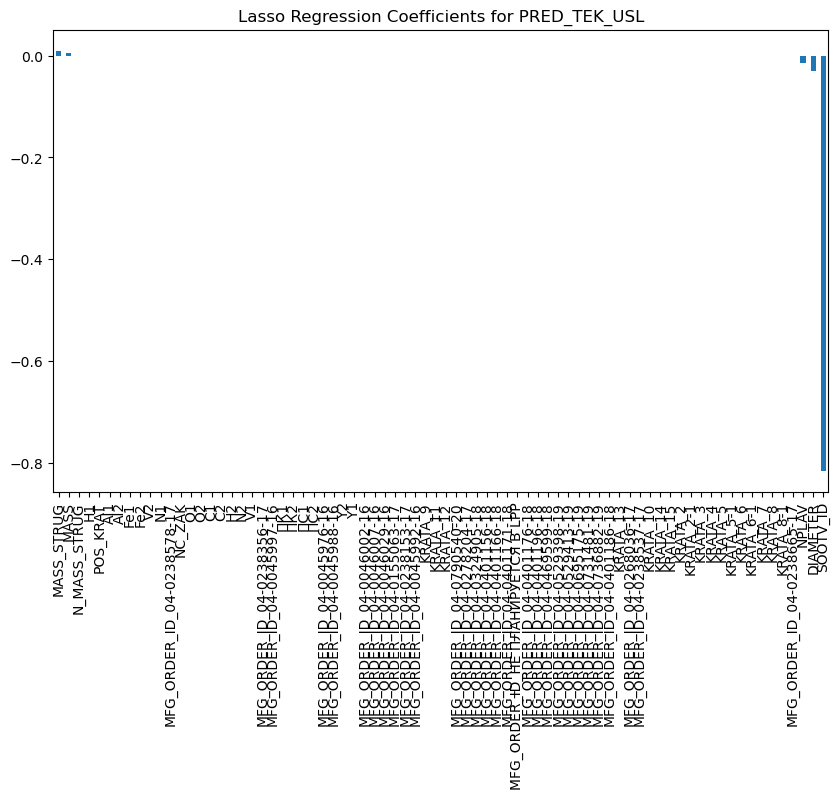

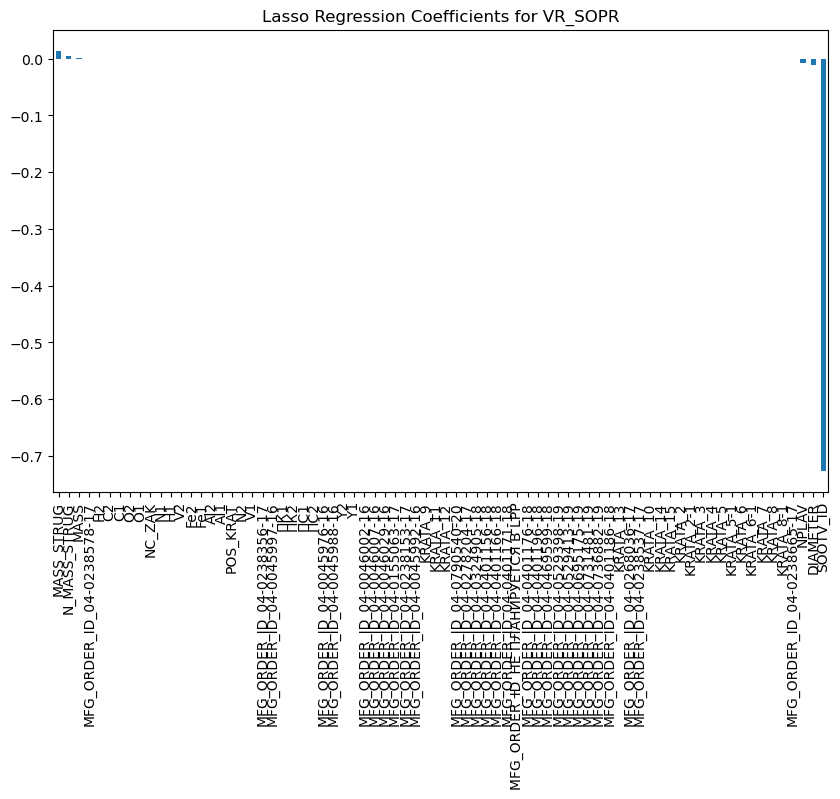

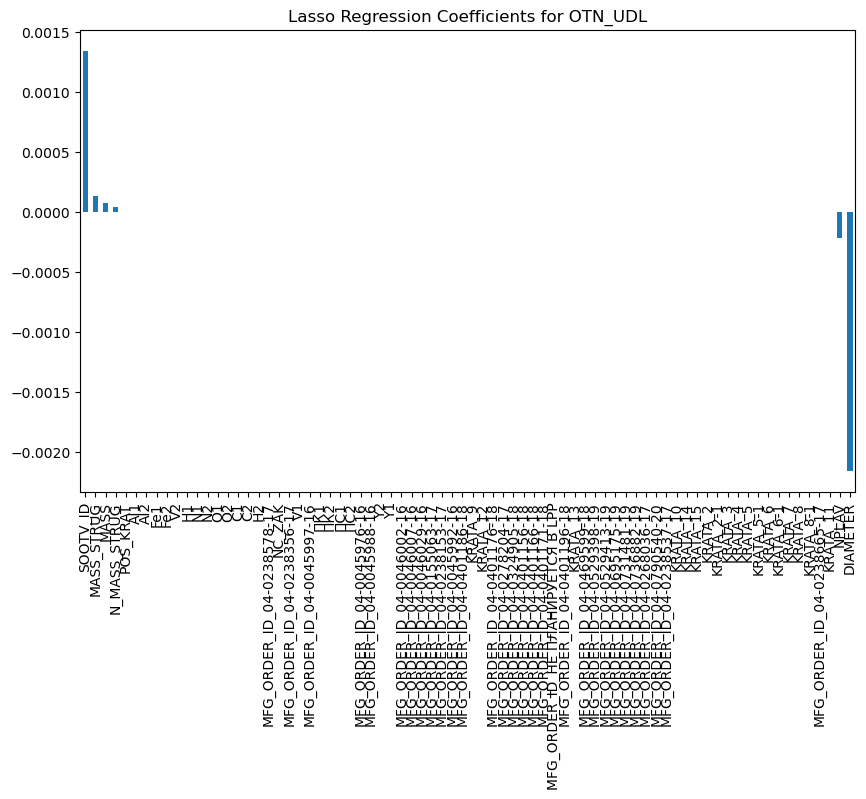

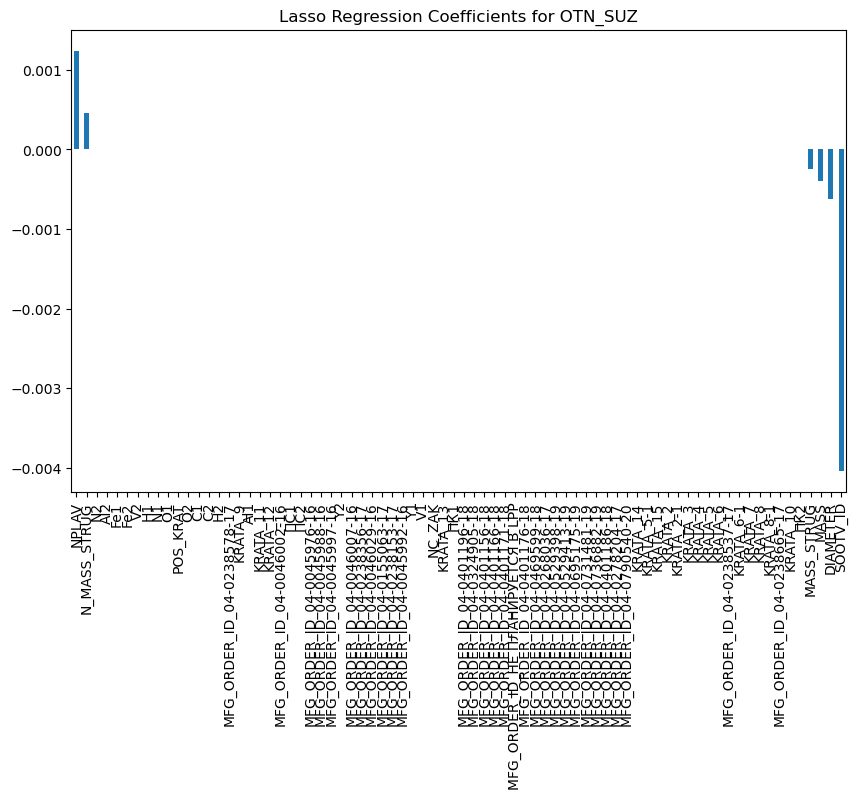


Features with zero weights for target 'PRED_TEK_USL':
MFG_ORDER_ID_04-0401186-18
MFG_ORDER_ID_04-0736882-19
MFG_ORDER_ID_04-0731481-19
MFG_ORDER_ID_04-0695175-19
MFG_ORDER_ID_04-0529413-19
MFG_ORDER_ID_04-0529398-19
MFG_ORDER_ID_04-0469599-18
MFG_ORDER_ID_04-0401196-18
MFG_ORDER_ID_04-0401176-18
MFG_ORDER_ID_НЕ ПЛАНИРУЕТСЯ В LPP
MFG_ORDER_ID_04-0401171-18
MFG_ORDER_ID_04-0401166-18
MFG_ORDER_ID_04-0401156-18
MFG_ORDER_ID_04-0324905-18
MFG_ORDER_ID_04-0278204-17
MFG_ORDER_ID_04-0268036-17
MFG_ORDER_ID_04-0790540-20
MFG_ORDER_ID_04-0238537-17
KRATA_10
MFG_ORDER_ID_04-0238665-17
KRATA_8-1
KRATA_8
KRATA_7
KRATA_6-1
KRATA_6
KRATA_5-1
KRATA_5
KRATA_4
KRATA_3
KRATA_2-1
KRATA_2
KRATA_15
KRATA_14
KRATA_13
KRATA_12
KRATA_11
KRATA_9
MFG_ORDER_ID_04-0238578-17
H2
C2
C1
O2
O1
N2
N1
H1
V2
Fe2
Fe1
Al2
Al1
POS_KRAT
NC_ZAK
MFG_ORDER_ID_04-0238356-17
V1
Y1
MFG_ORDER_ID_04-0045992-16
MFG_ORDER_ID_04-0238153-17
MFG_ORDER_ID_04-0155063-17
MFG_ORDER_ID_04-0046029-16
MFG_ORDER_ID_04-0046007-16
MFG_ORDER_ID_

In [319]:
from sklearn.linear_model import MultiTaskLassoCV


X = data.drop(columns=target_columns)
y = data[target_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso = MultiTaskLassoCV(cv=5, random_state=42).fit(X_train, y_train)

lasso_coefficients = pd.DataFrame(lasso.coef_, columns=X.columns, index=target_columns).T
lasso_coefficients = lasso_coefficients.sort_values(by=lasso_coefficients.columns[0], ascending=False)

print("Lasso regression coefficients:")
print(lasso_coefficients)

y_pred = lasso.predict(X_test)
r2_scores = {target: r2_score(y_test[target], y_pred[:, i]) for i, target in enumerate(target_columns)}

print("\n$R^2$ на тесте:")
for target, score in r2_scores.items():
    print(f"{target}: {score}")

# Visualization of Lasso regression coefficients for each target
for target in target_columns:
    plt.figure(figsize=(10, 6))
    lasso_coefficients[target].sort_values(ascending=False).plot(kind='bar')
    plt.title(f'Lasso Regression Coefficients for {target}')
    plt.show()
    
# Additional: Output the names of the features with zero weights
zero_weight_features = {}
for target in target_columns:
    zero_weights = lasso_coefficients[target][lasso_coefficients[target] == 0].index.tolist()
    zero_weight_features[target] = zero_weights
    print(f"\nFeatures with zero weights for target '{target}':")
    for feature in zero_weights:
        print(feature)

### Ансамблирование

In [322]:
X_train.shape

(3868, 76)


R^2 scores on test data:
PRED_TEK_USL: 0.09597522952668902
VR_SOPR: 0.10488698560053822
OTN_UDL: 0.08711844138339964
OTN_SUZ: 0.06651118823375213

Feature names sorted by mean importance:
['POS_KRAT', 'SOOTV_ID', 'O1', 'C1', 'NPLAV', 'O2', 'ПС2', 'ПС1', 'MASS', 'Al2', 'N_MASS_STRUG', 'V1', 'KRATA_2', 'Fe1', 'Al1', 'DIAMETER', 'V2', 'H1', 'N1', 'N2', 'H2', 'KRATA_5', 'KRATA_6', 'C2', 'KRATA_3', 'KRATA_7', 'KRATA_4', 'Fe2', 'KRATA_8', 'MFG_ORDER_ID_04-0401196-18', 'MFG_ORDER_ID_НЕ ПЛАНИРУЕТСЯ В LPP', 'MFG_ORDER_ID_04-0401176-18', 'MASS_STRUG', 'MFG_ORDER_ID_04-0045988-16', 'MFG_ORDER_ID_04-0731481-19', 'MFG_ORDER_ID_04-0529398-19', 'MFG_ORDER_ID_04-0238153-17', 'KRATA_9', 'MFG_ORDER_ID_04-0324905-18', 'MFG_ORDER_ID_04-0238356-17', 'MFG_ORDER_ID_04-0469599-18', 'MFG_ORDER_ID_04-0401156-18', 'MFG_ORDER_ID_04-0046029-16', 'MFG_ORDER_ID_04-0238665-17', 'MFG_ORDER_ID_04-0045976-16', 'MFG_ORDER_ID_04-0045997-16', 'KRATA_10', 'MFG_ORDER_ID_04-0238578-17', 'MFG_ORDER_ID_04-0790540-20', 'MFG_ORD

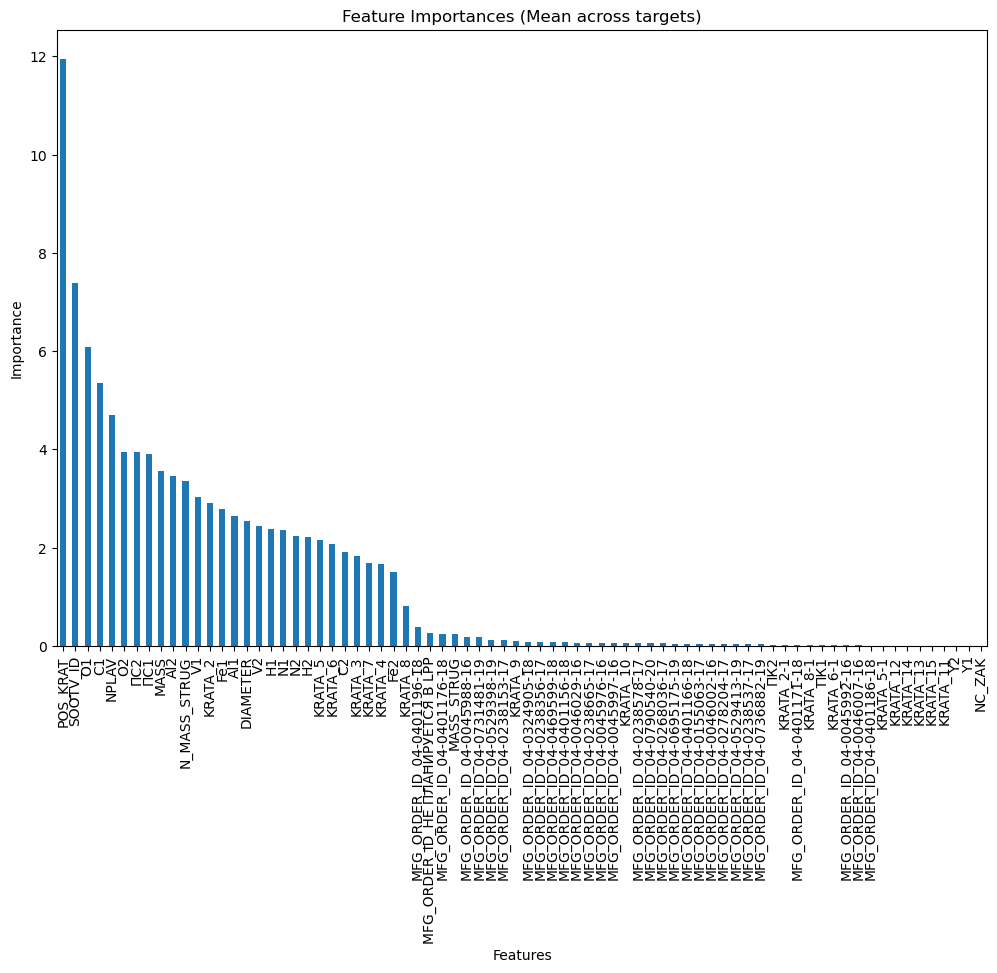


Feature names sorted by importance for PRED_TEK_USL:
['SOOTV_ID', 'O1', 'POS_KRAT', 'C1', 'ПС1', 'NPLAV', 'N_MASS_STRUG', 'ПС2', 'V1', 'MASS', 'Al2', 'KRATA_2', 'N2', 'N1', 'Fe1', 'H2', 'Al1', 'O2', 'H1', 'DIAMETER', 'V2', 'C2', 'KRATA_6', 'KRATA_4', 'KRATA_7', 'KRATA_5', 'Fe2', 'KRATA_3', 'KRATA_8', 'MFG_ORDER_ID_НЕ ПЛАНИРУЕТСЯ В LPP', 'MFG_ORDER_ID_04-0731481-19', 'MFG_ORDER_ID_04-0045988-16', 'MASS_STRUG', 'MFG_ORDER_ID_04-0401176-18', 'MFG_ORDER_ID_04-0529398-19', 'MFG_ORDER_ID_04-0046002-16', 'MFG_ORDER_ID_04-0469599-18', 'KRATA_9', 'MFG_ORDER_ID_04-0401196-18', 'MFG_ORDER_ID_04-0238578-17', 'MFG_ORDER_ID_04-0045976-16', 'MFG_ORDER_ID_04-0401166-18', 'MFG_ORDER_ID_04-0401171-18', 'MFG_ORDER_ID_04-0238665-17', 'KRATA_10', 'MFG_ORDER_ID_04-0268036-17', 'MFG_ORDER_ID_04-0278204-17', 'MFG_ORDER_ID_04-0529413-19', 'MFG_ORDER_ID_04-0238356-17', 'MFG_ORDER_ID_04-0401156-18', 'MFG_ORDER_ID_04-0695175-19', 'KRATA_2-1', 'MFG_ORDER_ID_04-0238153-17', 'MFG_ORDER_ID_04-0238537-17', 'MFG_ORDER

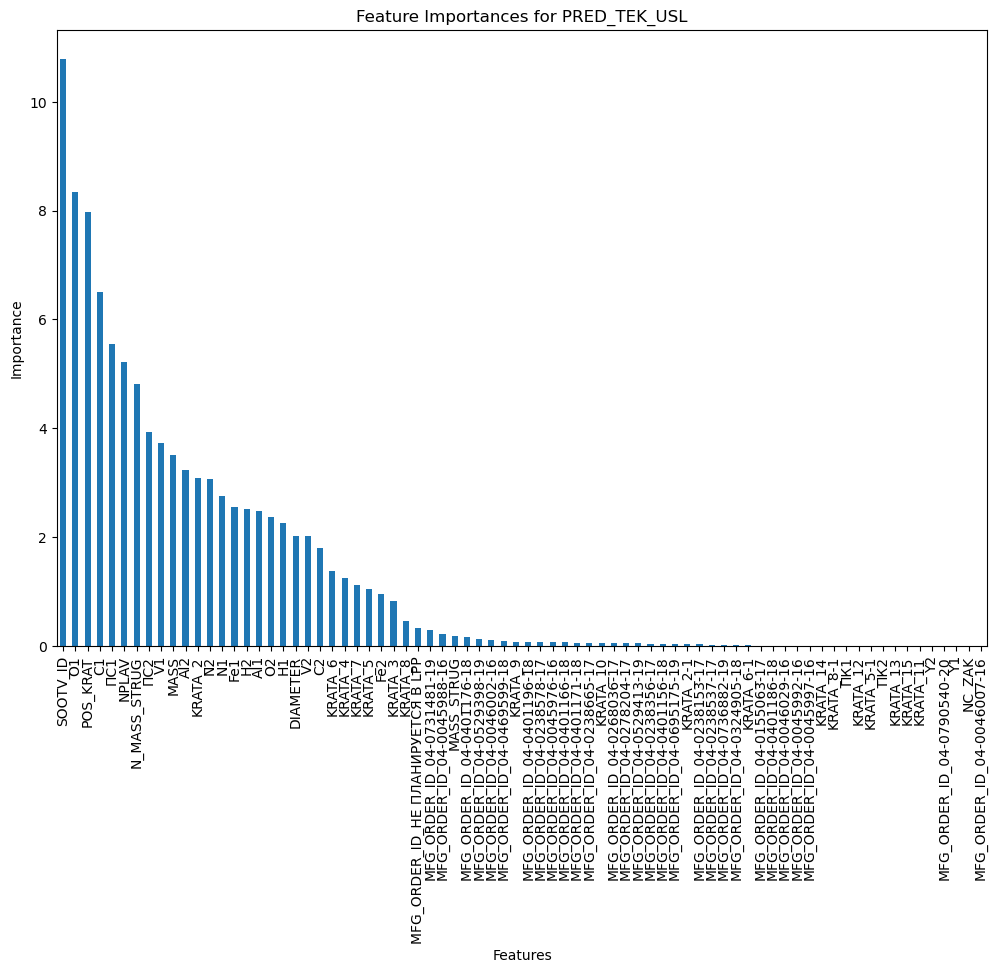


Feature names sorted by importance for VR_SOPR:
['SOOTV_ID', 'O1', 'C1', 'POS_KRAT', 'ПС2', 'NPLAV', 'ПС1', 'N_MASS_STRUG', 'V2', 'N1', 'V1', 'KRATA_2', 'Al2', 'MASS', 'N2', 'O2', 'DIAMETER', 'C2', 'Fe1', 'H2', 'Al1', 'KRATA_6', 'Fe2', 'H1', 'KRATA_5', 'KRATA_4', 'KRATA_7', 'KRATA_3', 'KRATA_8', 'MFG_ORDER_ID_НЕ ПЛАНИРУЕТСЯ В LPP', 'MASS_STRUG', 'MFG_ORDER_ID_04-0046029-16', 'MFG_ORDER_ID_04-0045988-16', 'MFG_ORDER_ID_04-0529398-19', 'MFG_ORDER_ID_04-0731481-19', 'MFG_ORDER_ID_04-0401176-18', 'MFG_ORDER_ID_04-0401196-18', 'MFG_ORDER_ID_04-0238665-17', 'MFG_ORDER_ID_04-0238578-17', 'MFG_ORDER_ID_04-0045976-16', 'MFG_ORDER_ID_04-0268036-17', 'KRATA_9', 'MFG_ORDER_ID_04-0469599-18', 'MFG_ORDER_ID_04-0401166-18', 'MFG_ORDER_ID_04-0046002-16', 'MFG_ORDER_ID_04-0238356-17', 'MFG_ORDER_ID_04-0695175-19', 'MFG_ORDER_ID_04-0401156-18', 'MFG_ORDER_ID_04-0324905-18', 'KRATA_10', 'MFG_ORDER_ID_04-0278204-17', 'MFG_ORDER_ID_04-0736882-19', 'ПК2', 'KRATA_2-1', 'MFG_ORDER_ID_04-0529413-19', 'MFG_ORD

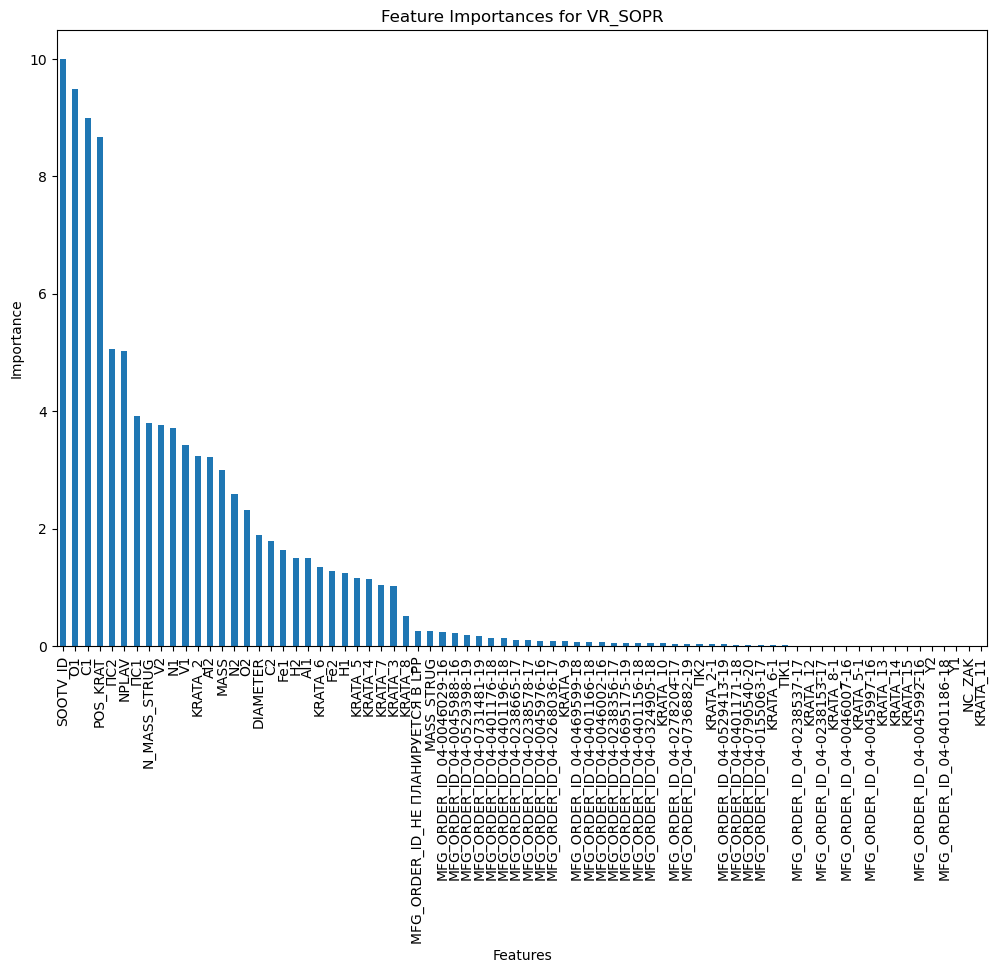


Feature names sorted by importance for OTN_UDL:
['POS_KRAT', 'O2', 'SOOTV_ID', 'Al2', 'Al1', 'Fe1', 'NPLAV', 'KRATA_5', 'KRATA_2', 'O1', 'H1', 'KRATA_6', 'H2', 'ПС1', 'DIAMETER', 'V1', 'ПС2', 'KRATA_3', 'KRATA_4', 'N_MASS_STRUG', 'V2', 'KRATA_7', 'C2', 'MASS', 'C1', 'N2', 'N1', 'Fe2', 'KRATA_8', 'MFG_ORDER_ID_04-0401196-18', 'MFG_ORDER_ID_04-0045988-16', 'MASS_STRUG', 'MFG_ORDER_ID_04-0238153-17', 'MFG_ORDER_ID_НЕ ПЛАНИРУЕТСЯ В LPP', 'MFG_ORDER_ID_04-0401156-18', 'KRATA_9', 'KRATA_8-1', 'MFG_ORDER_ID_04-0324905-18', 'MFG_ORDER_ID_04-0401176-18', 'MFG_ORDER_ID_04-0529413-19', 'MFG_ORDER_ID_04-0790540-20', 'MFG_ORDER_ID_04-0731481-19', 'MFG_ORDER_ID_04-0045976-16', 'MFG_ORDER_ID_04-0155063-17', 'MFG_ORDER_ID_04-0736882-19', 'MFG_ORDER_ID_04-0238537-17', 'MFG_ORDER_ID_04-0046007-16', 'MFG_ORDER_ID_04-0045992-16', 'MFG_ORDER_ID_04-0401166-18', 'MFG_ORDER_ID_04-0238356-17', 'MFG_ORDER_ID_04-0238665-17', 'MFG_ORDER_ID_04-0695175-19', 'KRATA_10', 'MFG_ORDER_ID_04-0268036-17', 'MFG_ORDER_ID_0

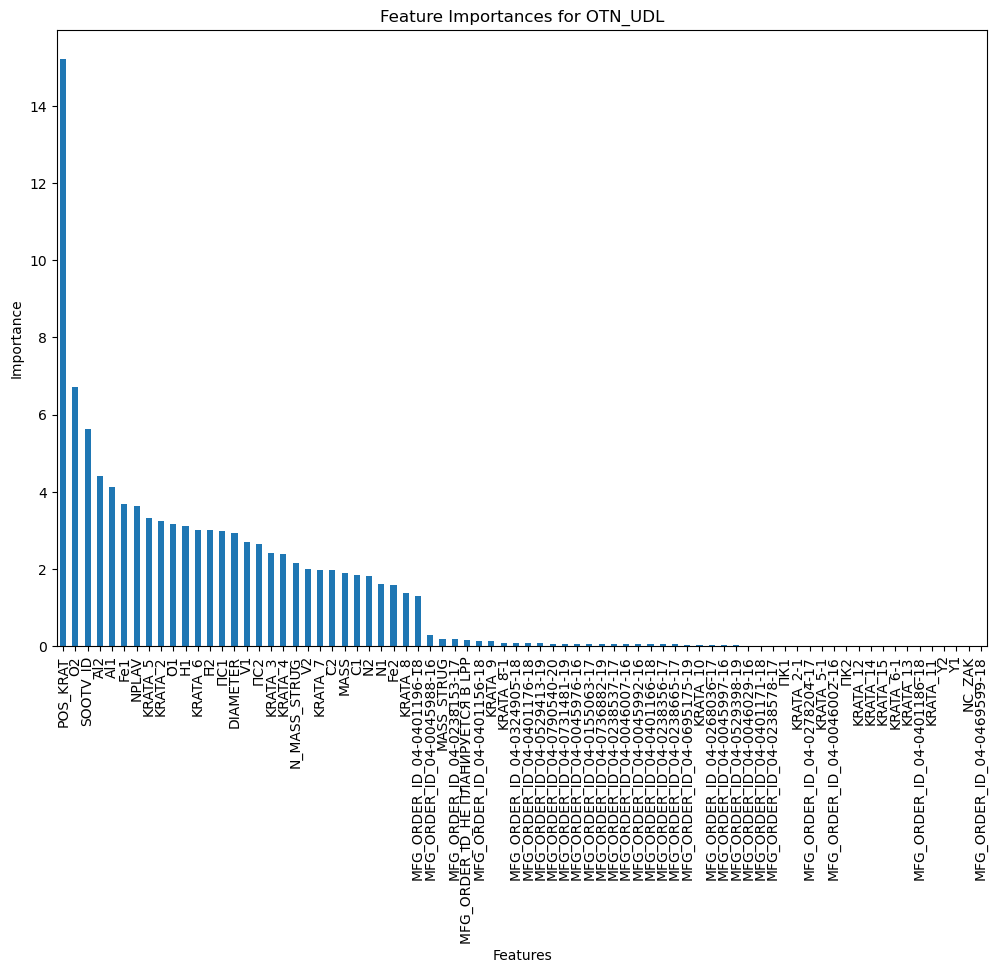


Feature names sorted by importance for OTN_SUZ:
['POS_KRAT', 'MASS', 'NPLAV', 'O2', 'ПС2', 'C1', 'O1', 'DIAMETER', 'Fe1', 'ПС1', 'SOOTV_ID', 'KRATA_5', 'KRATA_3', 'Al2', 'H1', 'N_MASS_STRUG', 'KRATA_7', 'KRATA_6', 'Al1', 'V1', 'Fe2', 'KRATA_2', 'C2', 'V2', 'KRATA_4', 'H2', 'N2', 'N1', 'KRATA_8', 'MFG_ORDER_ID_04-0401176-18', 'MASS_STRUG', 'MFG_ORDER_ID_НЕ ПЛАНИРУЕТСЯ В LPP', 'MFG_ORDER_ID_04-0238153-17', 'MFG_ORDER_ID_04-0731481-19', 'MFG_ORDER_ID_04-0045997-16', 'MFG_ORDER_ID_04-0324905-18', 'MFG_ORDER_ID_04-0238356-17', 'MFG_ORDER_ID_04-0529398-19', 'KRATA_9', 'MFG_ORDER_ID_04-0469599-18', 'MFG_ORDER_ID_04-0155063-17', 'MFG_ORDER_ID_04-0790540-20', 'ПК2', 'MFG_ORDER_ID_04-0278204-17', 'KRATA_10', 'MFG_ORDER_ID_04-0695175-19', 'ПК1', 'MFG_ORDER_ID_04-0401156-18', 'MFG_ORDER_ID_04-0238537-17', 'MFG_ORDER_ID_04-0238665-17', 'MFG_ORDER_ID_04-0268036-17', 'KRATA_2-1', 'MFG_ORDER_ID_04-0238578-17', 'KRATA_6-1', 'MFG_ORDER_ID_04-0045976-16', 'MFG_ORDER_ID_04-0401196-18', 'MFG_ORDER_ID_04-0

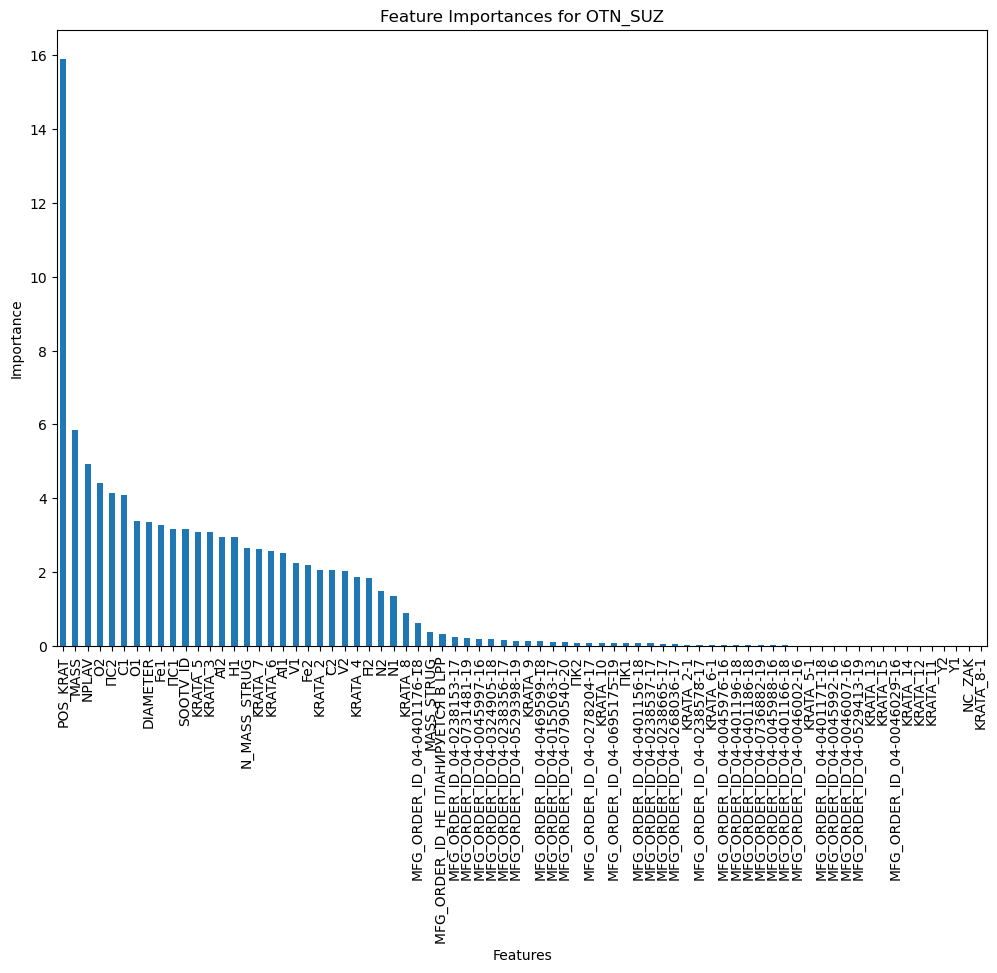

In [321]:
from catboost import CatBoostRegressor, Pool, cv


X = data.drop(columns=target_columns)
y = data[target_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

feature_importances = pd.DataFrame(index=X.columns)
r2_scores = {}

for target in target_columns:
    cb = CatBoostRegressor(random_state=42, verbose=0)
    cb.fit(X_train, y_train[target])

    y_pred = cb.predict(X_test)
    r2_scores[target] = r2_score(y_test[target], y_pred)

    # Vagnost' priznakov
    feature_importances[target] = cb.get_feature_importance(Pool(X_train, y_train[target]))

feature_importances['mean_importance'] = feature_importances.mean(axis=1)

print("\nR^2 scores on test data:")
for target, score in r2_scores.items():
    print(f"{target}: {score}")

sorted_features_mean = feature_importances['mean_importance'].sort_values(ascending=False)
print("\nFeature names sorted by mean importance:")
print(sorted_features_mean.index.tolist())

plt.figure(figsize=(12, 8))
sorted_features_mean.plot(kind='bar')
plt.title('Feature Importances (Mean across targets)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

for target in target_columns:
    sorted_features = feature_importances[target].sort_values(ascending=False)
    print(f"\nFeature names sorted by importance for {target}:")
    print(sorted_features.index.tolist())
    
    plt.figure(figsize=(12, 8))
    sorted_features.plot(kind='bar')
    plt.title(f'Feature Importances for {target}')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

In [249]:
# Попробуем удалить признак 'SOOTV_ID', так как его роль непонятна
data.drop(columns='SOOTV_ID', inplace=True)


R^2 scores on test data:
PRED_TEK_USL: 0.3873315847029112
VR_SOPR: 0.40698127815092233
OTN_UDL: 0.0708380045311342
OTN_SUZ: 0.07688592984544595

Feature names sorted by mean importance:
['POS_KRAT', 'O1', 'C1', 'O2', 'NPLAV', 'Al2', 'ПС2', 'N_MASS_STRUG', 'V1', 'MASS', 'ПС1', 'Fe1', 'V2', 'N2', 'Al1', 'H1', 'DIAMETER', 'H2', 'KRATA_2', 'KRATA_5', 'KRATA_6', 'N1', 'C2', 'KRATA_3', 'KRATA_4', 'KRATA_7', 'Fe2', 'KRATA_8', 'MFG_ORDER_ID_НЕ ПЛАНИРУЕТСЯ В LPP', 'MFG_ORDER_ID_04-0401196-18', 'MASS_STRUG', 'MFG_ORDER_ID_04-0401176-18', 'MFG_ORDER_ID_04-0731481-19', 'MFG_ORDER_ID_04-0045988-16', 'MFG_ORDER_ID_04-0238153-17', 'MFG_ORDER_ID_04-0401156-18', 'MFG_ORDER_ID_04-0324905-18', 'MFG_ORDER_ID_04-0046029-16', 'KRATA_9', 'MFG_ORDER_ID_04-0469599-18', 'MFG_ORDER_ID_04-0238578-17', 'MFG_ORDER_ID_04-0238356-17', 'MFG_ORDER_ID_04-0268036-17', 'MFG_ORDER_ID_04-0045976-16', 'MFG_ORDER_ID_04-0045997-16', 'MFG_ORDER_ID_04-0046002-16', 'MFG_ORDER_ID_04-0529398-19', 'MFG_ORDER_ID_04-0790540-20', 'KRA

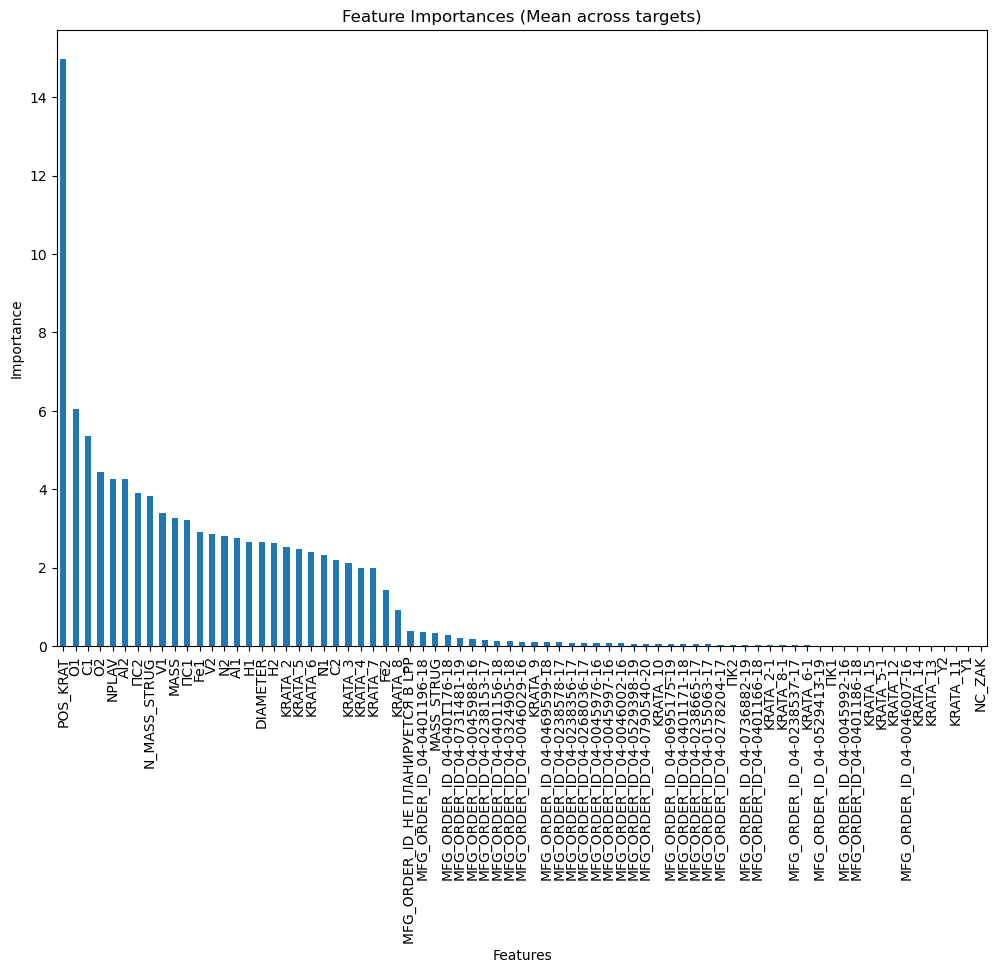


Feature names sorted by importance for PRED_TEK_USL:
['POS_KRAT', 'O1', 'C1', 'ПС1', 'Al2', 'N_MASS_STRUG', 'NPLAV', 'N2', 'H2', 'V1', 'O2', 'H1', 'ПС2', 'V2', 'MASS', 'N1', 'Fe1', 'DIAMETER', 'Al1', 'KRATA_2', 'KRATA_6', 'KRATA_4', 'KRATA_7', 'KRATA_5', 'C2', 'Fe2', 'KRATA_3', 'MFG_ORDER_ID_НЕ ПЛАНИРУЕТСЯ В LPP', 'KRATA_8', 'MFG_ORDER_ID_04-0731481-19', 'MASS_STRUG', 'MFG_ORDER_ID_04-0045988-16', 'MFG_ORDER_ID_04-0046002-16', 'MFG_ORDER_ID_04-0469599-18', 'MFG_ORDER_ID_04-0401176-18', 'MFG_ORDER_ID_04-0401171-18', 'MFG_ORDER_ID_04-0045976-16', 'MFG_ORDER_ID_04-0401196-18', 'KRATA_9', 'MFG_ORDER_ID_04-0401156-18', 'MFG_ORDER_ID_04-0268036-17', 'KRATA_10', 'MFG_ORDER_ID_04-0695175-19', 'MFG_ORDER_ID_04-0238665-17', 'MFG_ORDER_ID_04-0324905-18', 'MFG_ORDER_ID_04-0238578-17', 'KRATA_2-1', 'MFG_ORDER_ID_04-0238153-17', 'MFG_ORDER_ID_04-0529398-19', 'MFG_ORDER_ID_04-0401166-18', 'MFG_ORDER_ID_04-0278204-17', 'MFG_ORDER_ID_04-0238356-17', 'MFG_ORDER_ID_04-0155063-17', 'MFG_ORDER_ID_04-07368

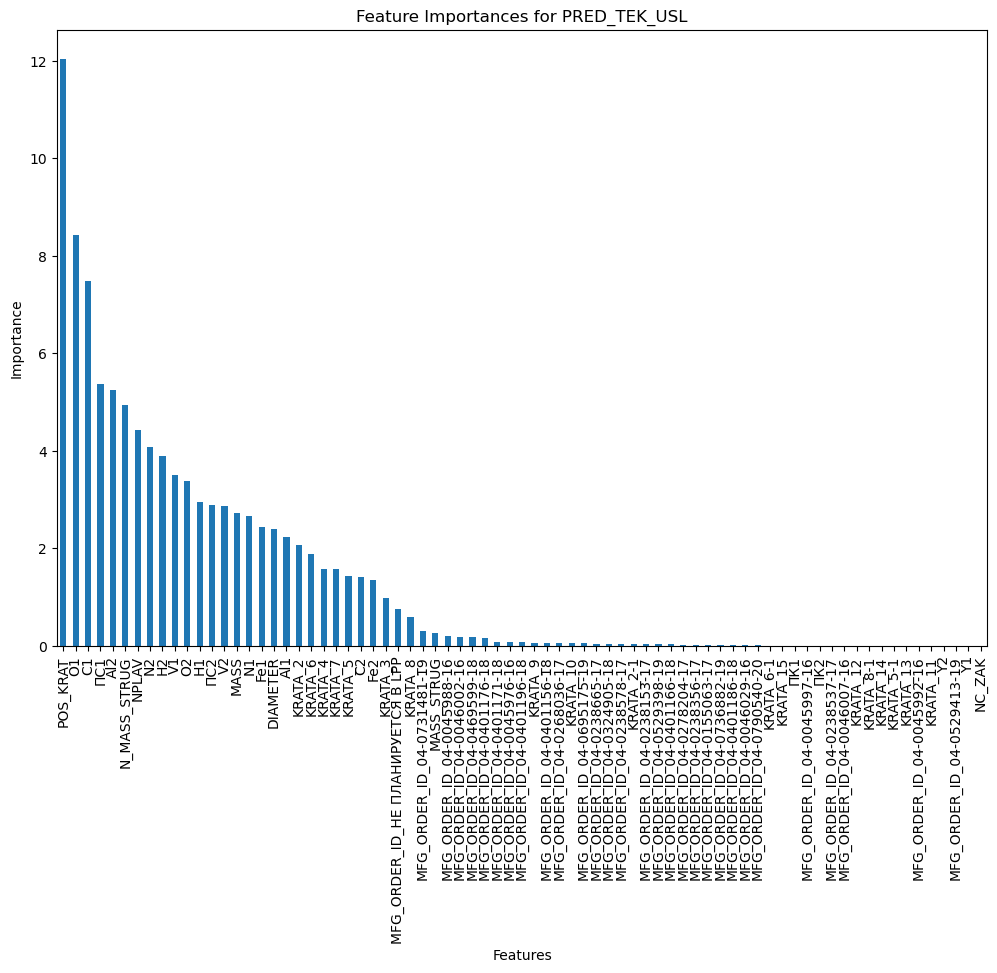


Feature names sorted by importance for VR_SOPR:
['POS_KRAT', 'O1', 'C1', 'ПС2', 'N_MASS_STRUG', 'NPLAV', 'V1', 'Al2', 'N1', 'V2', 'N2', 'C2', 'O2', 'MASS', 'Fe1', 'Al1', 'KRATA_2', 'KRATA_6', 'ПС1', 'H2', 'DIAMETER', 'KRATA_4', 'KRATA_7', 'H1', 'KRATA_5', 'KRATA_3', 'Fe2', 'KRATA_8', 'MASS_STRUG', 'MFG_ORDER_ID_НЕ ПЛАНИРУЕТСЯ В LPP', 'MFG_ORDER_ID_04-0046029-16', 'MFG_ORDER_ID_04-0238578-17', 'MFG_ORDER_ID_04-0045988-16', 'MFG_ORDER_ID_04-0324905-18', 'MFG_ORDER_ID_04-0469599-18', 'MFG_ORDER_ID_04-0268036-17', 'MFG_ORDER_ID_04-0401196-18', 'MFG_ORDER_ID_04-0401156-18', 'MFG_ORDER_ID_04-0401176-18', 'MFG_ORDER_ID_04-0731481-19', 'MFG_ORDER_ID_04-0045976-16', 'MFG_ORDER_ID_04-0401171-18', 'KRATA_9', 'MFG_ORDER_ID_04-0695175-19', 'MFG_ORDER_ID_04-0401166-18', 'KRATA_10', 'MFG_ORDER_ID_04-0790540-20', 'KRATA_2-1', 'ПК2', 'MFG_ORDER_ID_04-0046002-16', 'MFG_ORDER_ID_04-0238356-17', 'MFG_ORDER_ID_04-0238665-17', 'MFG_ORDER_ID_04-0736882-19', 'MFG_ORDER_ID_04-0155063-17', 'MFG_ORDER_ID_04-027

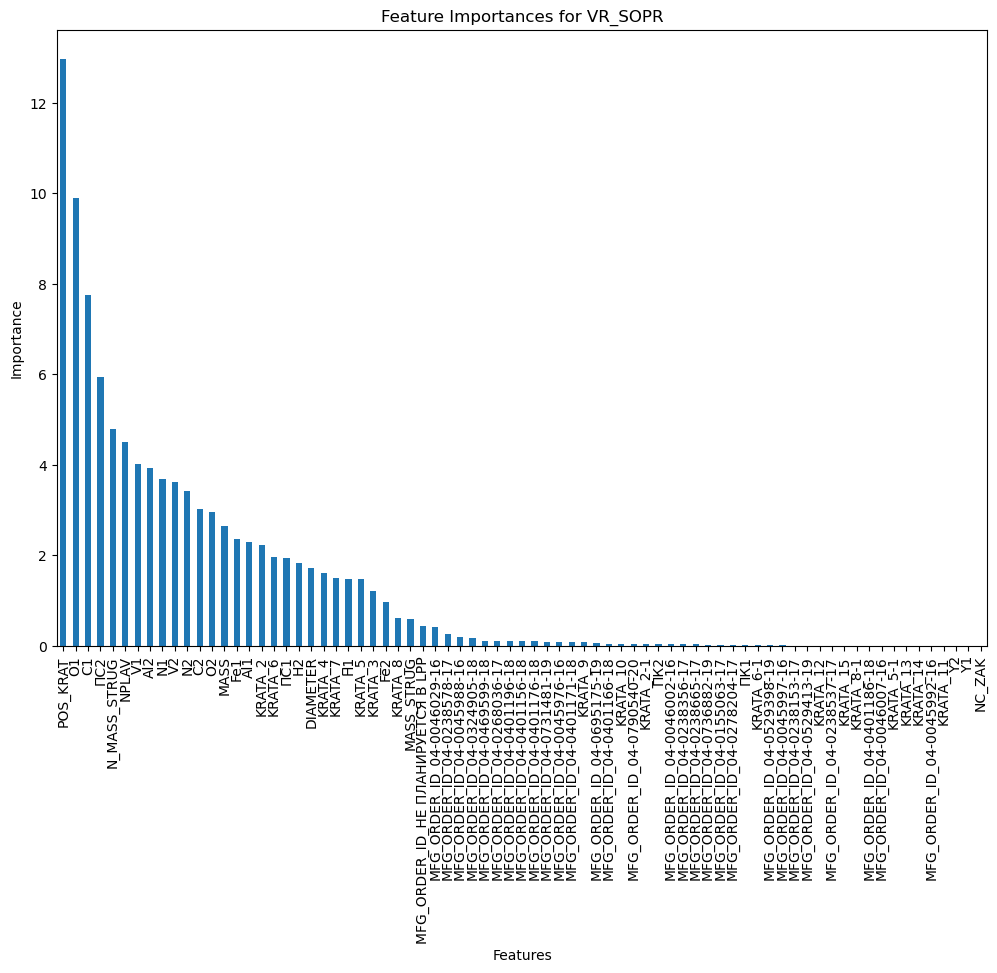


Feature names sorted by importance for OTN_UDL:
['POS_KRAT', 'O2', 'Al2', 'H1', 'KRATA_2', 'KRATA_5', 'NPLAV', 'Fe1', 'Al1', 'DIAMETER', 'KRATA_6', 'V2', 'V1', 'N_MASS_STRUG', 'KRATA_3', 'O1', 'ПС1', 'H2', 'KRATA_4', 'ПС2', 'KRATA_7', 'MASS', 'C1', 'C2', 'N2', 'N1', 'KRATA_8', 'Fe2', 'MFG_ORDER_ID_04-0401196-18', 'MFG_ORDER_ID_04-0401156-18', 'MFG_ORDER_ID_04-0045988-16', 'MASS_STRUG', 'MFG_ORDER_ID_04-0238153-17', 'MFG_ORDER_ID_04-0401176-18', 'KRATA_9', 'KRATA_8-1', 'MFG_ORDER_ID_НЕ ПЛАНИРУЕТСЯ В LPP', 'MFG_ORDER_ID_04-0736882-19', 'MFG_ORDER_ID_04-0731481-19', 'MFG_ORDER_ID_04-0238356-17', 'MFG_ORDER_ID_04-0155063-17', 'MFG_ORDER_ID_04-0045976-16', 'MFG_ORDER_ID_04-0324905-18', 'MFG_ORDER_ID_04-0790540-20', 'MFG_ORDER_ID_04-0529398-19', 'MFG_ORDER_ID_04-0045997-16', 'MFG_ORDER_ID_04-0529413-19', 'MFG_ORDER_ID_04-0238665-17', 'MFG_ORDER_ID_04-0278204-17', 'MFG_ORDER_ID_04-0268036-17', 'MFG_ORDER_ID_04-0238537-17', 'MFG_ORDER_ID_04-0045992-16', 'MFG_ORDER_ID_04-0695175-19', 'MFG_ORDE

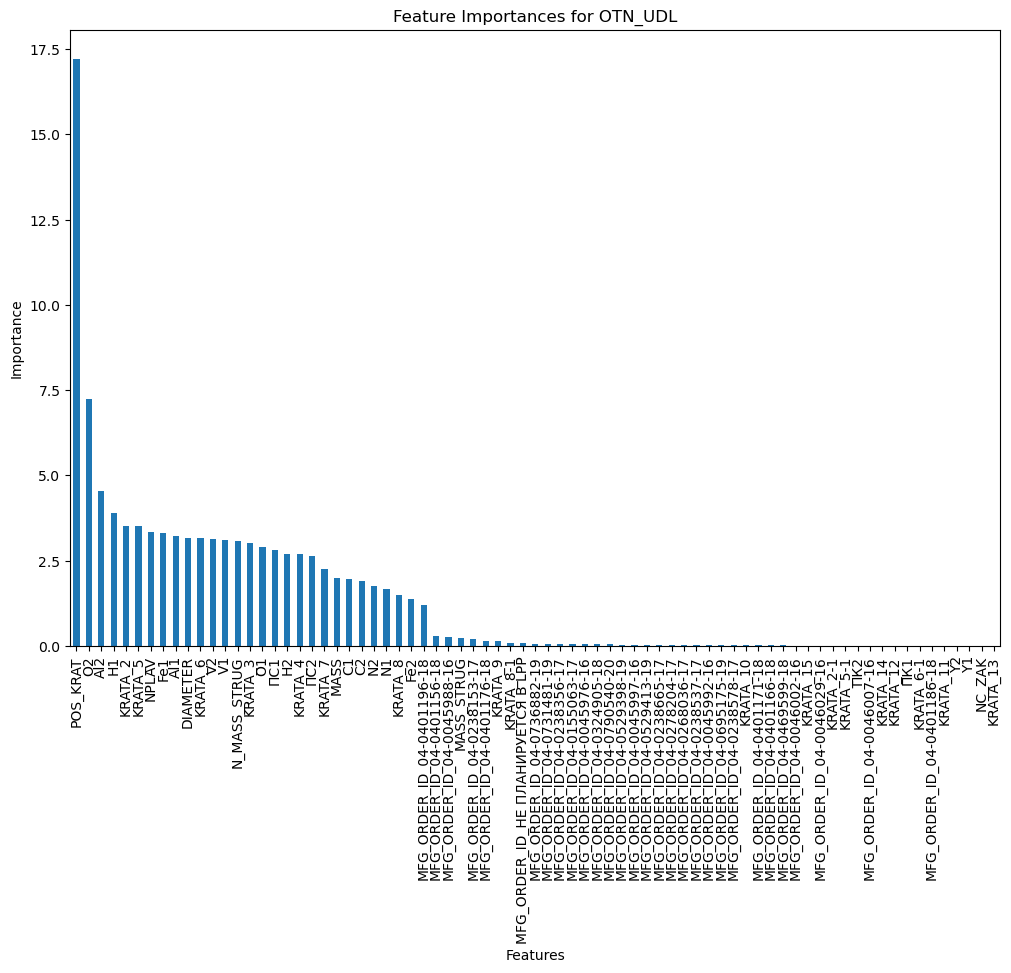


Feature names sorted by importance for OTN_SUZ:
['POS_KRAT', 'MASS', 'NPLAV', 'C1', 'O2', 'ПС2', 'Fe1', 'KRATA_5', 'Al2', 'DIAMETER', 'KRATA_3', 'Al1', 'O1', 'V1', 'ПС1', 'KRATA_7', 'KRATA_6', 'N_MASS_STRUG', 'C2', 'KRATA_2', 'H1', 'KRATA_4', 'H2', 'Fe2', 'N2', 'V2', 'N1', 'KRATA_8', 'MFG_ORDER_ID_04-0401176-18', 'MFG_ORDER_ID_04-0238153-17', 'MFG_ORDER_ID_04-0731481-19', 'MFG_ORDER_ID_НЕ ПЛАНИРУЕТСЯ В LPP', 'MFG_ORDER_ID_04-0324905-18', 'MFG_ORDER_ID_04-0045997-16', 'MASS_STRUG', 'MFG_ORDER_ID_04-0238356-17', 'MFG_ORDER_ID_04-0529398-19', 'KRATA_9', 'MFG_ORDER_ID_04-0790540-20', 'MFG_ORDER_ID_04-0268036-17', 'KRATA_10', 'ПК2', 'MFG_ORDER_ID_04-0469599-18', 'MFG_ORDER_ID_04-0155063-17', 'MFG_ORDER_ID_04-0695175-19', 'MFG_ORDER_ID_04-0238578-17', 'MFG_ORDER_ID_04-0401156-18', 'MFG_ORDER_ID_04-0278204-17', 'MFG_ORDER_ID_04-0045976-16', 'MFG_ORDER_ID_04-0238665-17', 'MFG_ORDER_ID_04-0045988-16', 'MFG_ORDER_ID_04-0238537-17', 'KRATA_2-1', 'MFG_ORDER_ID_04-0401196-18', 'KRATA_6-1', 'MFG_OR

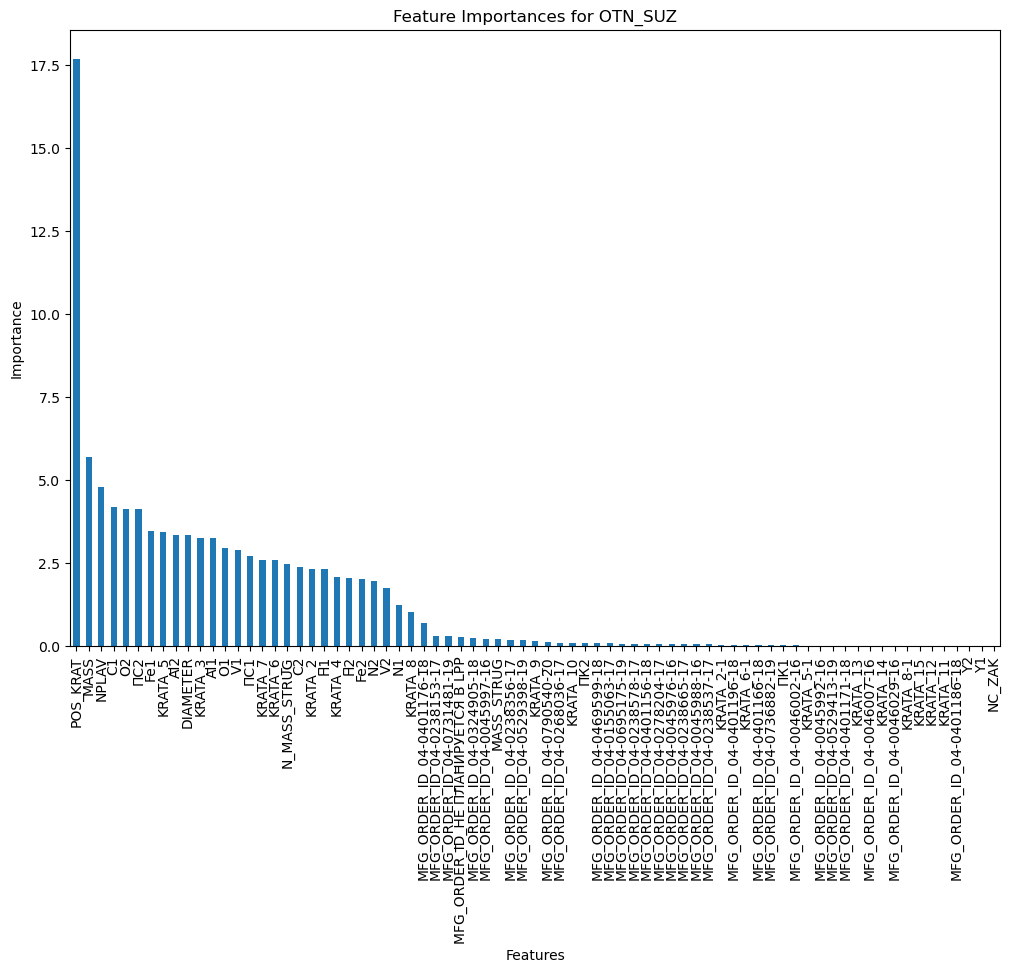

In [251]:
X = data.drop(columns=target_columns)
y = data[target_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

feature_importances = pd.DataFrame(index=X.columns)
r2_scores = {}

for target in target_columns:
    cb = CatBoostRegressor(random_state=42, verbose=0)
    cb.fit(X_train, y_train[target])

    y_pred = cb.predict(X_test)
    r2_scores[target] = r2_score(y_test[target], y_pred)

    # Vagnost' priznakov
    feature_importances[target] = cb.get_feature_importance(Pool(X_train, y_train[target]))

feature_importances['mean_importance'] = feature_importances.mean(axis=1)

print("\nR^2 scores on test data:")
for target, score in r2_scores.items():
    print(f"{target}: {score}")

sorted_features_mean = feature_importances['mean_importance'].sort_values(ascending=False)
print("\nFeature names sorted by mean importance:")
print(sorted_features_mean.index.tolist())

plt.figure(figsize=(12, 8))
sorted_features_mean.plot(kind='bar')
plt.title('Feature Importances (Mean across targets)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

for target in target_columns:
    sorted_features = feature_importances[target].sort_values(ascending=False)
    print(f"\nFeature names sorted by importance for {target}:")
    print(sorted_features.index.tolist())
    
    plt.figure(figsize=(12, 8))
    sorted_features.plot(kind='bar')
    plt.title(f'Feature Importances for {target}')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

# Вычисление среднего времени работы алгоритмов бустинга

In [3]:
import time

In [12]:
def get_avg_time(estimator, params, X, target, n_runs=3):
    times = []
    for i in range(n_runs):
        X_train, X_val, X_test, y_train, y_val, y_test = preprocess_random(X, target, i)
        start_time = time.time()
        model = estimator(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        end_time = time.time()
        times.append(end_time - start_time)
    return np.mean(times), np.std(times)

### Automobile

In [6]:
# Fetch and preprocess data
automobile = fetch_ucirepo(id=10)
X = automobile.data.features
y = automobile.data.targets
X = X[~X['price'].isna()].reset_index()
# X_train, X_val, X_test, y_train, y_val, y_test = preprocess(X, 'price')


# Define best hyperparameters
best_params = {
    'BoostingElementaryPredicatesv2': {'num_iter': 300, 'm': 5, 'max_cov': 500, 'learning_rate': 0.1},
    'LightGBM': {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.1, 'num_threads': 1, 'verbose': -1},
    'CatBoost': {'score_function': 'Cosine', 'learning_rate': 0.1, 'grow_policy': 'SymmetricTree', 'depth': 3, 'thread_count': 1}
}

results = {}
for algorithm, params in best_params.items():
    if algorithm == 'BoostingElementaryPredicatesv2':
        avg_time, std_time = get_avg_time(BoostingElementaryPredicatesv2, params, X, 'price')
    elif algorithm == 'LightGBM':
        avg_time, std_time = get_avg_time(LGBMRegressor, params, X, 'price')
    elif algorithm == 'CatBoost':
        avg_time, std_time = get_avg_time(CatBoostRegressor, params, X, 'price')
    elif algorithm == 'GBRegressor':
        avg_time, std_time = get_avg_time(GradientBoostingRegressor, params, X, 'price')
    results[algorithm] = {'Average Time': avg_time, 'Std Dev Time': std_time}

# Display results in a table
results_df = pd.DataFrame(results).T

results_df.to_csv(f'time_Automobile.csv')

print(results_df)

0:	learn: 6418.9217691	total: 62.6ms	remaining: 1m 2s
1:	learn: 6054.8063087	total: 64ms	remaining: 31.9s
2:	learn: 5735.2388905	total: 65ms	remaining: 21.6s
3:	learn: 5427.5118250	total: 65.7ms	remaining: 16.4s
4:	learn: 5140.0625756	total: 66.2ms	remaining: 13.2s
5:	learn: 4889.9310544	total: 66.8ms	remaining: 11.1s
6:	learn: 4630.5065645	total: 67.4ms	remaining: 9.55s
7:	learn: 4475.8767048	total: 67.9ms	remaining: 8.42s
8:	learn: 4298.6290295	total: 68.5ms	remaining: 7.54s
9:	learn: 4114.7162272	total: 69ms	remaining: 6.83s
10:	learn: 3952.6604772	total: 69.6ms	remaining: 6.25s
11:	learn: 3763.6331814	total: 70.1ms	remaining: 5.77s
12:	learn: 3626.5403012	total: 70.6ms	remaining: 5.36s
13:	learn: 3482.5272397	total: 71.1ms	remaining: 5.01s
14:	learn: 3332.6549243	total: 71.5ms	remaining: 4.7s
15:	learn: 3245.4312529	total: 72ms	remaining: 4.43s
16:	learn: 3137.7893516	total: 72.5ms	remaining: 4.19s
17:	learn: 3035.4274140	total: 73.1ms	remaining: 3.99s
18:	learn: 2948.4762871	total

### Servo

In [13]:
servo = fetch_ucirepo(id=87) 
  
# data (as pandas dataframes) 
X = servo.data.features 
y = servo.data.targets 

data = pd.concat([X, y], axis=1)

encoder_motor = LabelEncoder()
encoder_screw = LabelEncoder()

data['motor'] = encoder_motor.fit_transform(data['motor'])
data['screw'] = encoder_screw.fit_transform(data['screw'])

# X_train, X_val, X_test, y_train, y_val, y_test = preprocess(data, 'class')


# Define best hyperparameters
best_params = {
    'BoostingElementaryPredicatesv2': {'num_iter': 600, 'max_cov': 500, 'm': 3, 'learning_rate': 0.1},
    'LightGBM': {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.1, 'num_threads': 1, 'verbose': -1},
    'CatBoost': {'score_function': 'Cosine', 'learning_rate': 0.1, 'grow_policy': 'SymmetricTree', 'depth': 3, 'thread_count': 1},
    'GBRegressor': {'n_estimators': 100, 'max_depth': 3}
}

# Perform the timing
results = {}
for algorithm, params in best_params.items():
    if algorithm == 'BoostingElementaryPredicatesv2':
        avg_time, std_time = get_avg_time(BoostingElementaryPredicatesv2, params, data, 'class')
    elif algorithm == 'LightGBM':
        avg_time, std_time = get_avg_time(LGBMRegressor, params, data, 'class')
    elif algorithm == 'CatBoost':
        avg_time, std_time = get_avg_time(CatBoostRegressor, params, data, 'class')
    elif algorithm == 'GBRegressor':
        avg_time, std_time = get_avg_time(GradientBoostingRegressor, params, data, 'class')
    results[algorithm] = {'Average Time': avg_time, 'Std Dev Time': std_time}

# Display results in a table
results_df = pd.DataFrame(results).T

results_df.to_csv('time_Servo.csv')

print(results_df)


0:	learn: 1.4523778	total: 2.82ms	remaining: 2.82s
1:	learn: 1.3695929	total: 3.82ms	remaining: 1.91s
2:	learn: 1.3132690	total: 4.72ms	remaining: 1.57s
3:	learn: 1.2368540	total: 5.54ms	remaining: 1.38s
4:	learn: 1.1658536	total: 6.09ms	remaining: 1.21s
5:	learn: 1.1059315	total: 6.75ms	remaining: 1.12s
6:	learn: 1.0603953	total: 7.57ms	remaining: 1.07s
7:	learn: 1.0167012	total: 9.01ms	remaining: 1.12s
8:	learn: 0.9742799	total: 10.5ms	remaining: 1.16s
9:	learn: 0.9291717	total: 11.8ms	remaining: 1.17s
10:	learn: 0.8896833	total: 12.6ms	remaining: 1.13s
11:	learn: 0.8447446	total: 13.2ms	remaining: 1.09s
12:	learn: 0.8070987	total: 13.9ms	remaining: 1.06s
13:	learn: 0.7710414	total: 14.5ms	remaining: 1.02s
14:	learn: 0.7451350	total: 15.3ms	remaining: 1s
15:	learn: 0.7149551	total: 16.1ms	remaining: 987ms
16:	learn: 0.6878823	total: 16.4ms	remaining: 947ms
17:	learn: 0.6632805	total: 17ms	remaining: 927ms
18:	learn: 0.6374301	total: 17.6ms	remaining: 910ms
19:	learn: 0.6121583	total:

### Computer Hardware

In [9]:
computer_hardware = fetch_ucirepo(id=29) 
  
# data (as pandas dataframes) 
X = computer_hardware.data.features 
y = computer_hardware.data.targets 

X = X.drop(columns='ModelName', axis=1)

best_params = {
    'BoostingElementaryPredicatesv2': {'num_iter': 600, 'max_cov': 500, 'm': 3, 'learning_rate': 0.1},
    'LightGBM': {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.1, 'num_threads': 1, 'verbose': -1},
    'CatBoost': {'score_function': 'Cosine', 'learning_rate': 0.1, 'grow_policy': 'SymmetricTree', 'depth': 3, 'thread_count': 1},
    'GBRegressor': {'n_estimators': 100, 'max_depth': 3}
}

results = {}
for algorithm, params in best_params.items():
    if algorithm == 'BoostingElementaryPredicatesv2':
        avg_time, std_time = get_avg_time(BoostingElementaryPredicatesv2, params, X, 'PRP')
    elif algorithm == 'LightGBM':
        avg_time, std_time = get_avg_time(LGBMRegressor, params, X, 'PRP')
    elif algorithm == 'CatBoost':
        avg_time, std_time = get_avg_time(CatBoostRegressor, params, X, 'PRP')
    elif algorithm == 'GBRegressor':
        avg_time, std_time = get_avg_time(GradientBoostingRegressor, params, X, 'PRP')
    results[algorithm] = {'Average Time': avg_time, 'Std Dev Time': std_time}

# Display results in a table
results_df = pd.DataFrame(results).T

results_df.to_csv('time_Computers.csv')

print(results_df)

0:	learn: 131.4008017	total: 691us	remaining: 691ms
1:	learn: 124.9957854	total: 1.23ms	remaining: 616ms
2:	learn: 119.0639721	total: 1.38ms	remaining: 460ms
3:	learn: 113.7564674	total: 1.51ms	remaining: 377ms
4:	learn: 108.7197405	total: 1.66ms	remaining: 331ms
5:	learn: 104.2976113	total: 1.79ms	remaining: 296ms
6:	learn: 100.0648497	total: 1.93ms	remaining: 273ms
7:	learn: 95.8174131	total: 2.06ms	remaining: 256ms
8:	learn: 92.5966511	total: 2.19ms	remaining: 241ms
9:	learn: 91.1932852	total: 2.31ms	remaining: 229ms
10:	learn: 87.8789192	total: 2.45ms	remaining: 220ms
11:	learn: 84.8034793	total: 2.58ms	remaining: 212ms
12:	learn: 82.0380078	total: 2.71ms	remaining: 206ms
13:	learn: 78.9987940	total: 2.85ms	remaining: 200ms
14:	learn: 77.8374675	total: 2.97ms	remaining: 195ms
15:	learn: 75.4749856	total: 3.09ms	remaining: 190ms
16:	learn: 74.1778642	total: 3.21ms	remaining: 186ms
17:	learn: 72.0728563	total: 3.33ms	remaining: 182ms
18:	learn: 70.5834636	total: 3.46ms	remaining: 178

### Air Quality

In [10]:
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
X = air_quality.data.features 
y = air_quality.data.targets 

X['Date'] = pd.to_datetime(X['Date'], format='%m/%d/%Y')
X['Month']= X['Date'].dt.month  
X['Hour']=X['Time'].apply(lambda x: int(x.split(':')[0]))

X = X.drop(['Date', 'Time'], axis=1)

# X_train, X_val, X_test, y_train, y_val, y_test = preprocess(X, 'RH')

best_params = {
    'BoostingElementaryPredicatesv2': {'num_iter': 525, 'max_cov': 500, 'm': 15, 'learning_rate': 0.5},
    'LightGBM': {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.1, 'num_threads': 1, 'verbose': -1},
    'CatBoost': {'score_function': 'Cosine', 'learning_rate': 0.1, 'grow_policy': 'SymmetricTree', 'depth': 3, 'thread_count': 1},
    'GBRegressor': {'n_estimators': 100, 'max_depth': 3}
}

results = {}
for algorithm, params in best_params.items():
    if algorithm == 'BoostingElementaryPredicatesv2':
        avg_time, std_time = get_avg_time(BoostingElementaryPredicatesv2, params, X, 'RH')
    elif algorithm == 'LightGBM':
        avg_time, std_time = get_avg_time(LGBMRegressor, params, X, 'RH')
    elif algorithm == 'CatBoost':
        avg_time, std_time = get_avg_time(CatBoostRegressor, params, X, 'RH')
    elif algorithm == 'GBRegressor':
        avg_time, std_time = get_avg_time(GradientBoostingRegressor, params, X, 'RH')
    results[algorithm] = {'Average Time': avg_time, 'Std Dev Time': std_time}

# Display results in a table
results_df = pd.DataFrame(results).T

results_df.to_csv('time_AirQ.csv')

print(results_df)

0:	learn: 46.8090683	total: 2.84ms	remaining: 2.84s
1:	learn: 42.6473665	total: 4.12ms	remaining: 2.06s
2:	learn: 38.9216990	total: 5.29ms	remaining: 1.76s
3:	learn: 35.5548808	total: 6.48ms	remaining: 1.61s
4:	learn: 32.7311658	total: 7.73ms	remaining: 1.54s
5:	learn: 29.9798096	total: 8.97ms	remaining: 1.49s
6:	learn: 27.6450474	total: 10.4ms	remaining: 1.48s
7:	learn: 25.5612765	total: 11.7ms	remaining: 1.45s
8:	learn: 23.6293745	total: 12.9ms	remaining: 1.42s
9:	learn: 21.8997280	total: 14.1ms	remaining: 1.39s
10:	learn: 20.3601007	total: 15.2ms	remaining: 1.36s
11:	learn: 18.9987113	total: 16.3ms	remaining: 1.34s
12:	learn: 17.9141938	total: 17.4ms	remaining: 1.32s
13:	learn: 16.8116900	total: 18.6ms	remaining: 1.31s
14:	learn: 15.9874558	total: 19.7ms	remaining: 1.29s
15:	learn: 15.2164461	total: 20.8ms	remaining: 1.28s
16:	learn: 14.4328141	total: 21.9ms	remaining: 1.27s
17:	learn: 13.8389259	total: 23ms	remaining: 1.26s
18:	learn: 13.2386570	total: 24.1ms	remaining: 1.24s
19:	l

### Auto MPG

In [11]:
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 

data = pd.concat([X, y], axis=1)

data = data.dropna()

# X_train, X_val, X_test, y_train, y_val, y_test = preprocess(data, 'mpg')

best_params = {
    'BoostingElementaryPredicatesv2': {'num_iter': 600, 'max_cov': 500, 'm': 3, 'learning_rate': 0.1},
    'LightGBM': {'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.1, 'num_threads': 1, 'verbose': -1},
    'CatBoost': {'score_function': 'Cosine', 'learning_rate': 0.1, 'grow_policy': 'SymmetricTree', 'depth': 9, 'thread_count': 1},
    'GBRegressor': {'n_estimators': 50, 'max_depth': 3}
}

results = {}
for algorithm, params in best_params.items():
    if algorithm == 'BoostingElementaryPredicatesv2':
        avg_time, std_time = get_avg_time(BoostingElementaryPredicatesv2, params, data, 'mpg')
    elif algorithm == 'LightGBM':
        avg_time, std_time = get_avg_time(LGBMRegressor, params, data, 'mpg')
    elif algorithm == 'CatBoost':
        avg_time, std_time = get_avg_time(CatBoostRegressor, params, data, 'mpg')
    elif algorithm == 'GBRegressor':
        avg_time, std_time = get_avg_time(GradientBoostingRegressor, params, data, 'mpg')
    results[algorithm] = {'Average Time': avg_time, 'Std Dev Time': std_time}

# Display results in a table
results_df = pd.DataFrame(results).T

results_df.to_csv('time_auto_mpg.csv')

print(results_df)

0:	learn: 7.3621900	total: 5.85ms	remaining: 5.85s
1:	learn: 6.8774002	total: 9.49ms	remaining: 4.74s
2:	learn: 6.3872716	total: 13.6ms	remaining: 4.53s
3:	learn: 5.9633213	total: 16.3ms	remaining: 4.06s
4:	learn: 5.5772288	total: 18.9ms	remaining: 3.76s
5:	learn: 5.2479058	total: 19.7ms	remaining: 3.26s
6:	learn: 4.9319054	total: 22.2ms	remaining: 3.16s
7:	learn: 4.6511986	total: 23ms	remaining: 2.85s
8:	learn: 4.4003498	total: 26.4ms	remaining: 2.9s
9:	learn: 4.1718859	total: 29.4ms	remaining: 2.91s
10:	learn: 3.9542907	total: 29.7ms	remaining: 2.67s
11:	learn: 3.7651666	total: 32.3ms	remaining: 2.66s
12:	learn: 3.5861920	total: 34.9ms	remaining: 2.65s
13:	learn: 3.4365156	total: 37.4ms	remaining: 2.63s
14:	learn: 3.3074599	total: 40.1ms	remaining: 2.63s
15:	learn: 3.1913398	total: 43.6ms	remaining: 2.68s
16:	learn: 3.0844746	total: 46.6ms	remaining: 2.69s
17:	learn: 2.9846677	total: 49.2ms	remaining: 2.68s
18:	learn: 2.8968577	total: 51.7ms	remaining: 2.67s
19:	learn: 2.8220411	tota

### Yachts

In [17]:
data = pd.read_csv('datasets/02_yachts.csv', sep=',', header=None)

# X_train, X_val, X_test, y_train, y_val, y_test = preprocess(data, 6)

best_params = {
    'BoostingElementaryPredicatesv2': {'num_iter': 375, 'max_cov': 500, 'm': 15, 'learning_rate': 0.1},
    'LightGBM': {'num_leaves': 2, 'max_depth': 3, 'learning_rate': 0.1, 'num_threads': 1, 'verbose': -1},
    'CatBoost': {'score_function': 'L2', 'learning_rate': 0.1, 'grow_policy': 'SymmetricTree', 'depth': 5, 'thread_count': 1},
    'GBRegressor': {'n_estimators': 300, 'max_depth': 3}
}

results = {}
for algorithm, params in best_params.items():
    if algorithm == 'BoostingElementaryPredicatesv2':
        avg_time, std_time = get_avg_time(BoostingElementaryPredicatesv2, params, data, 6)
    elif algorithm == 'LightGBM':
        avg_time, std_time = get_avg_time(LGBMRegressor, params, data, 6)
    elif algorithm == 'CatBoost':
        avg_time, std_time = get_avg_time(CatBoostRegressor, params, data, 6)
    elif algorithm == 'GBRegressor':
        avg_time, std_time = get_avg_time(GradientBoostingRegressor, params, data, 6)
    results[algorithm] = {'Average Time': avg_time, 'Std Dev Time': std_time}

# Display results in a table
results_df = pd.DataFrame(results).T

results_df.to_csv('time_yachts.csv')

print(results_df)

0:	learn: 14.3012173	total: 622us	remaining: 622ms
1:	learn: 13.0550719	total: 1.09ms	remaining: 544ms
2:	learn: 11.9224299	total: 1.36ms	remaining: 452ms
3:	learn: 10.8935344	total: 1.53ms	remaining: 382ms
4:	learn: 9.9585031	total: 1.71ms	remaining: 340ms
5:	learn: 9.1047617	total: 1.87ms	remaining: 310ms
6:	learn: 8.3293424	total: 2.01ms	remaining: 285ms
7:	learn: 7.6264299	total: 2.18ms	remaining: 270ms
8:	learn: 6.9889313	total: 2.4ms	remaining: 264ms
9:	learn: 6.4128910	total: 2.56ms	remaining: 253ms
10:	learn: 5.8899312	total: 2.69ms	remaining: 242ms
11:	learn: 5.4177261	total: 2.82ms	remaining: 232ms
12:	learn: 4.9907953	total: 2.95ms	remaining: 224ms
13:	learn: 4.6049925	total: 3.08ms	remaining: 217ms
14:	learn: 4.2597348	total: 3.2ms	remaining: 210ms
15:	learn: 3.9461668	total: 3.33ms	remaining: 205ms
16:	learn: 3.6650529	total: 3.46ms	remaining: 200ms
17:	learn: 3.4108832	total: 3.59ms	remaining: 196ms
18:	learn: 3.1849169	total: 3.72ms	remaining: 192ms
19:	learn: 2.9667491	